In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator 
from scipy.signal import correlate
from statsmodels.tsa.stattools import adfuller, pacf, acf
from scipy.stats import shapiro, probplot, norm # shapiro wilk test for normality sample size thousands or fewer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import random
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults

# Import Data

In [2]:
def importdata(key, path ,parseCol, From="2004-01-01", To="2019-09-01"):
    ''' 
    make sure the end date of the parse is shared between all datasets
    '''
    dataset = pd.read_csv("%s" %(path), index_col="%s" %(parseCol), parse_dates=["%s" %(parseCol)])
    if From==None and To==None:
        pass
    elif From and To:
        dataset = dataset.loc[From:To]
    return dataset

# enter the path where the data has been saved
# import_PATH = r"\\ad.ucl.ac.uk\home0\zcecss0\DesktopSettings\Desktop\Research project\Data"    
import_PATH = r"C:\Users\sherv\OneDrive\Documents\GitHub\Python-Projects\Research Project\Data"
# enter the path you want the figures to be saved in 
# this is not neccessary as you can simply copy and paste the figures from the output
save_PATH = r"C:\Users\sherv\OneDrive\Documents\GitHub\Python-Projects\Research Project\Plots_Main"

meta = {# dataset: [path, Date_col, Value_col]
        "Google":[f"{import_PATH}\multiTimeline.csv", "Month", "Top5"], 
        "RDPI":  [f"{import_PATH}\RealDisposableIncome-2004-1_Present-Mon-US(Grab-30-11-18).csv", "DATE", "DSPIC96"], 
        "CPI":   [f"{import_PATH}\CPI.csv", "DATE", "CPI"],
#        "GDP":   [f"{import_PATH}\GDP.csv", "DATE", "GDP"], 
#        "UE":    [f"{import_PATH}\Unemployment_2004_Present_US(Grab-5-12-18).csv", "DATE", "Value"], 
        "SP500": [f"{import_PATH}\S&P500.csv", "Date", "Close"], 
#        "IR":    [f"{import_PATH}\InterestRate_2004-1-1_Present_US(Grab-5-12-18).csv", "DATE", "FEDFUNDS"], 
#        "PPI":   [f"{import_PATH}\PPIACO.csv", "DATE", "PPI"],
#        "PMI":   [f"{import_PATH}\ISM-MAN_PMI.csv", "Date", "PMI"],
#        "DJI":   [f"{import_PATH}\DJI.csv", "Date", "Close"]
}

data ={}
for key in meta.keys():
    data[key] = importdata(key, meta[key][0], meta[key][1])

# Visualise Data

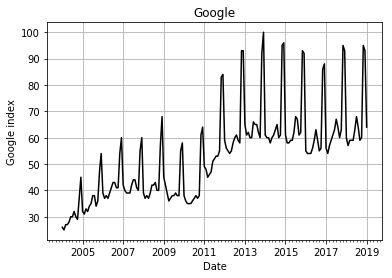

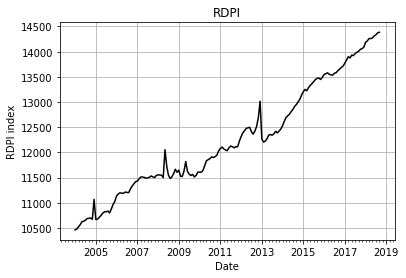

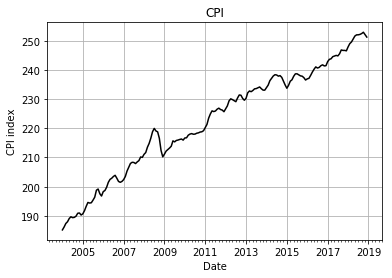

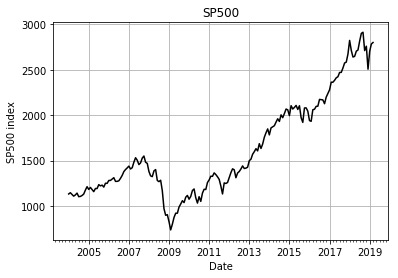

In [9]:
minor_locator = AutoMinorLocator(12)
for key in data.keys():
    fig, ax1 = plt.subplots()
    data[key][meta[key][2]].plot(ax=ax1,color='k').xaxis.set_minor_locator(minor_locator)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f"{key} index", color='k')
    plt.grid()
    Title = f"{key}"
    plt.title(Title)
#    plt.savefig("%s\%s.png" %(save_PATH, Title))

1. Google data is limited to the dates ["2004-01-01":"2019-09-01"]
2. data undergoes structural break from 2008 to 2009 so model is best to be fit from 2009 onwards
3. train data is to be 95% of available data after parse

In [3]:
SP = data["SP500"]["Close"].loc["2009-01-01":"2018-12-01"]
# DJI= data["DJI"]["Close"].loc["2009-01-01":"2018-12-01"]
GGL = data["Google"][meta["Google"][2]].loc["2009-01-01":"2018-12-01"]
RDPI = data["RDPI"]["DSPIC96"].loc["2009-01-01":"2018-12-01"]
CPI = data["CPI"][meta["CPI"][2]].loc["2009-01-01":"2018-12-01"]

In [6]:
def boxcox_optimise(data, Title=""):
    print(Title)
    print("No transform QQ correlation:",round(probplot(data, rvalue=True)[-1][-1],3) )
    for lambd in range(-5,6):
        if lambd != 0:
            transform = data**lambd
        else:
            transform = np.log(data)
        print(f"lambda={lambd} QQ correlation",round(probplot(transform, rvalue=True)[-1][-1],3))
        
boxcox_optimise(SP, "SP")
boxcox_optimise(RDPI, "RDPI")
boxcox_optimise(CPI, "CPI")
# boxcox_optimise(data["Google"]["Top5"], "GGL")


SP
No transform QQ correlation: 0.983
lambda=-5 QQ correlation 0.685
lambda=-4 QQ correlation 0.763
lambda=-3 QQ correlation 0.843
lambda=-2 QQ correlation 0.912
lambda=-1 QQ correlation 0.96
lambda=0 QQ correlation 0.983
lambda=1 QQ correlation 0.983
lambda=2 QQ correlation 0.966
lambda=3 QQ correlation 0.937
lambda=4 QQ correlation 0.902
lambda=5 QQ correlation 0.865
RDPI
No transform QQ correlation: 0.972
lambda=-5 QQ correlation 0.973
lambda=-4 QQ correlation 0.974
lambda=-3 QQ correlation 0.975
lambda=-2 QQ correlation 0.975
lambda=-1 QQ correlation 0.975
lambda=0 QQ correlation 0.974
lambda=1 QQ correlation 0.972
lambda=2 QQ correlation 0.97
lambda=3 QQ correlation 0.968
lambda=4 QQ correlation 0.965
lambda=5 QQ correlation 0.961
CPI
No transform QQ correlation: 0.986
lambda=-5 QQ correlation 0.969
lambda=-4 QQ correlation 0.973
lambda=-3 QQ correlation 0.976
lambda=-2 QQ correlation 0.979
lambda=-1 QQ correlation 0.982
lambda=0 QQ correlation 0.984
lambda=1 QQ correlation 0.986


In [7]:
print("No transform QQ correlation:",round(probplot(GGL, rvalue=True)[-1][-1],3) )
for lambd in range(-5,6):
    if lambd != 0 :
        transform = [i**lambd for i in GGL]
    else:
        transform = np.log(GGL)
    print(f"lambda={lambd} QQ correlation",round(probplot(transform, rvalue=True)[-1][-1],3))


No transform QQ correlation: 0.941
lambda=-5 QQ correlation 0.786
lambda=-4 QQ correlation 0.82
lambda=-3 QQ correlation 0.861
lambda=-2 QQ correlation 0.905
lambda=-1 QQ correlation 0.942
lambda=0 QQ correlation 0.958
lambda=1 QQ correlation 0.941
lambda=2 QQ correlation 0.898
lambda=3 QQ correlation 0.845
lambda=4 QQ correlation 0.794
lambda=5 QQ correlation 0.752


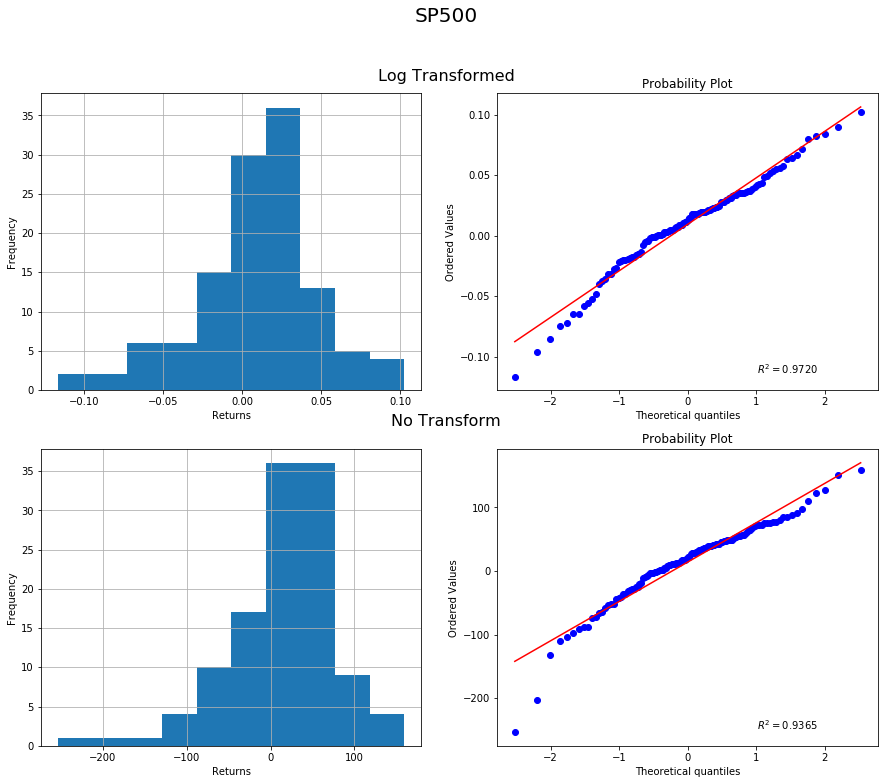

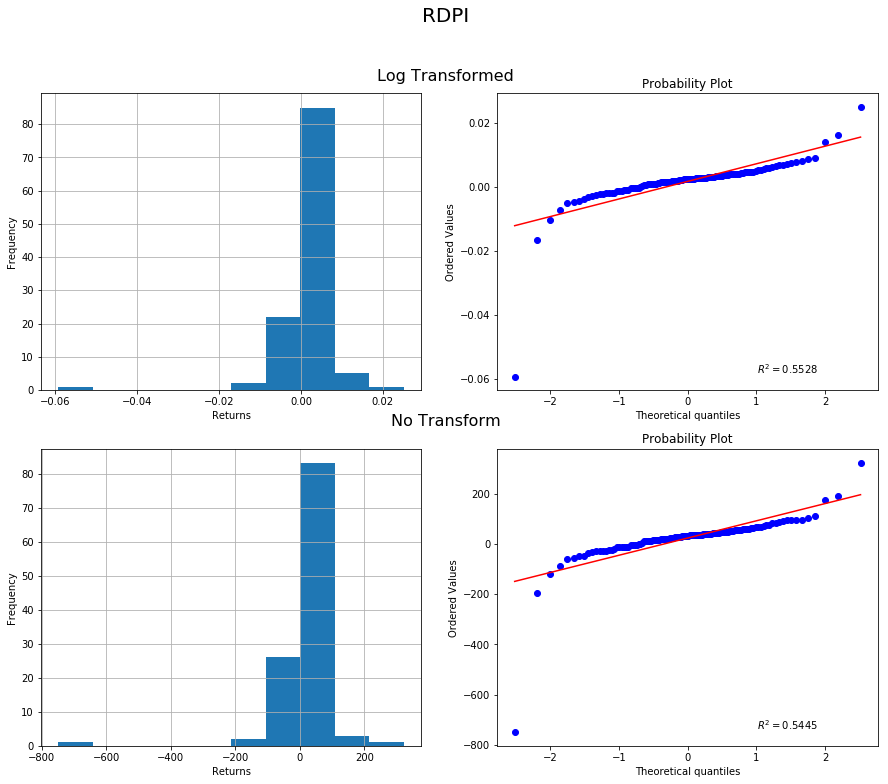

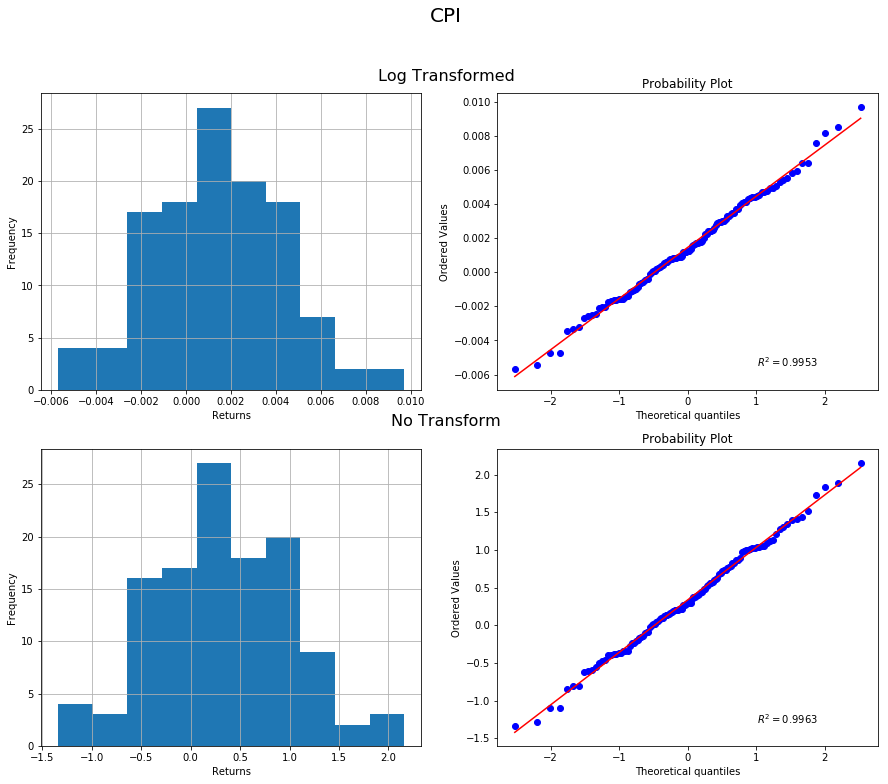

In [23]:
def boxcox(data, Title=""):
    fig, ax = plt.subplots(2,2, figsize=[15,12])
    fig.suptitle(Title, fontsize=20)
    np.log(data).diff(1).hist(ax=ax[0,0])
    ax[0,0].set(ylabel="Frequency", xlabel="Returns")
    probplot(np.log(data).diff(1).dropna(),plot=ax[0,1], rvalue=True);
    fig.text(0.5,0.5,"No Transform", ha="center", va="center", fontsize=16)
    fig.text(0.5,0.9,"Log Transformed", ha="center", va="center", fontsize=16)
    data.diff(1).hist(ax=ax[1,0])
    ax[1,0].set(ylabel="Frequency", xlabel="Returns")
    probplot(data.diff(1).dropna(),plot=ax[1,1], rvalue=True);
    
boxcox(SP, "SP500")
# boxcox(GGL, "GGL")
boxcox(RDPI, "RDPI")
boxcox(CPI, "CPI")


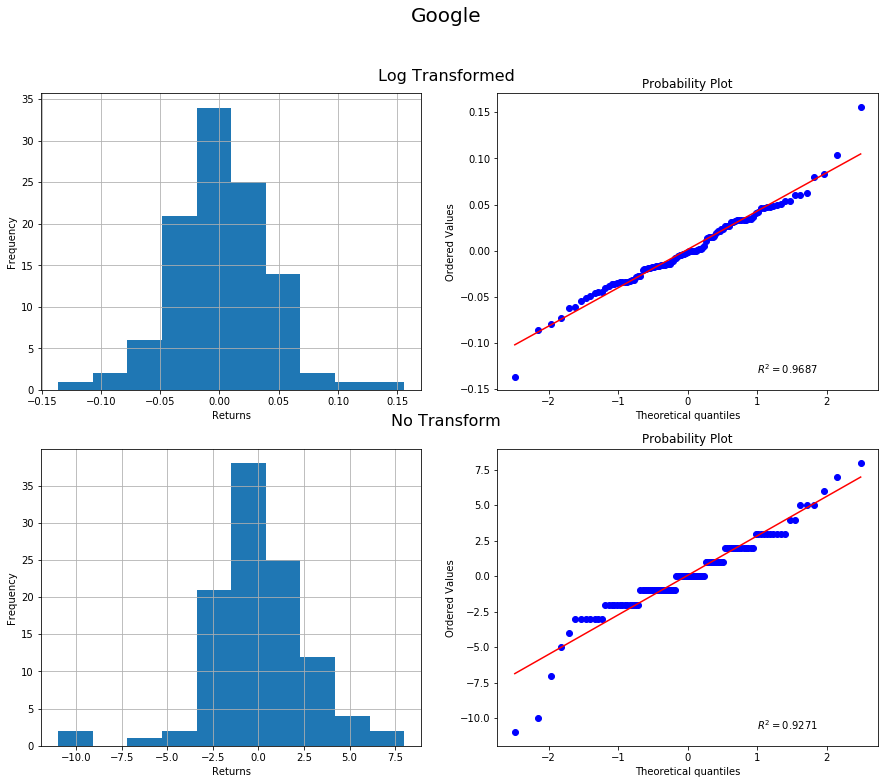

In [111]:
fig, ax = plt.subplots(2,2, figsize=[15,12])
fig.suptitle("Google", fontsize=20)
np.log(GGL).diff(12).diff(1).dropna().hist(ax=ax[0,0])
ax[0,0].set(ylabel="Frequency", xlabel="Returns")
probplot(np.log(GGL).diff(12).diff(1).dropna(),plot=ax[0,1], rvalue=True);
fig.text(0.5,0.5,"No Transform", ha="center", va="center", fontsize=16)
fig.text(0.5,0.9,"Log Transformed", ha="center", va="center", fontsize=16)
GGL.diff(12).diff(1).hist(ax=ax[1,0])
ax[1,0].set(ylabel="Frequency", xlabel="Returns")
probplot(GGL.diff(12).diff(1).dropna(),plot=ax[1,1], rvalue=True);


# Data evaluation

1. Is variance constant over time? 
- Plot yearly variance (or growth rate), If growth present take logarithm
2. Is there seasonality?
- plot month's data over the years in box plot to compare seasonality
3. Is data stationary? 
- If ADF test, If no difference until stationary


#### Seasonality

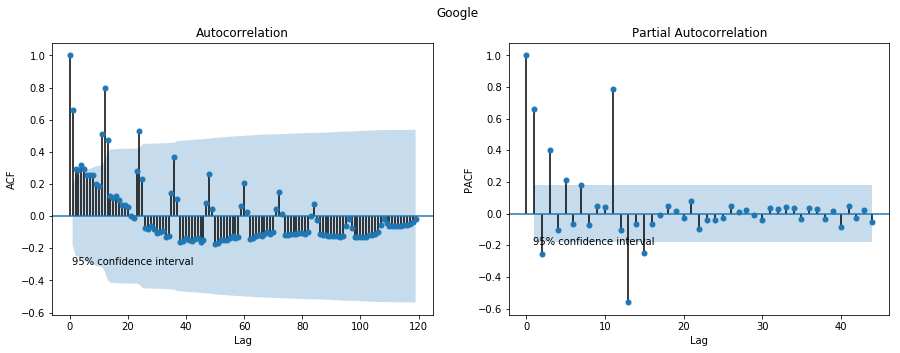

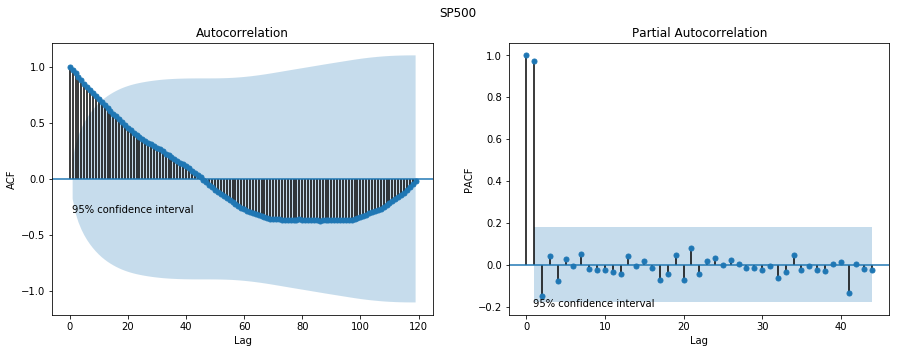

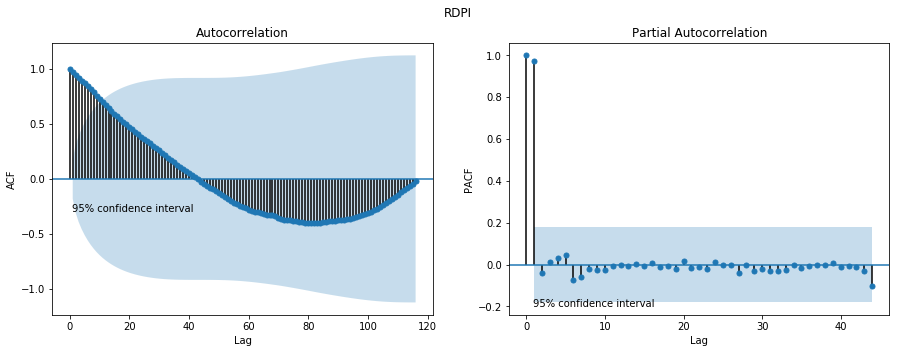

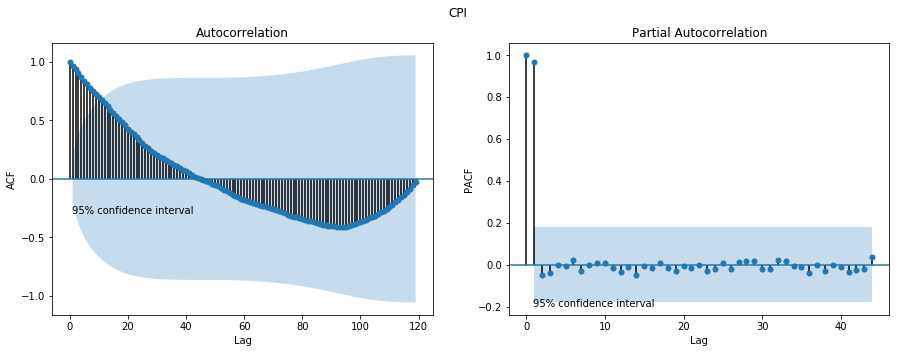

In [48]:
def acfpacf(data, Title):
    fig, axes = plt.subplots(1,2, figsize=[15,5])
    plt.suptitle(Title)
    plot_acf(data, ax=axes[0])
    axes[0].set(xlabel="Lag", ylabel="ACF")
    axes[0].text(0.8, -0.3,"95% confidence interval")
    
    plot_pacf(data, ax=axes[1], method="ywmle", lags=44)
    axes[1].set(xlabel="Lag", ylabel="PACF")
    axes[1].text(0.8, -0.2,"95% confidence interval")

    
acfpacf(GGL, "Google")
acfpacf(SP, "SP500");
acfpacf(RDPI, "RDPI");
acfpacf(CPI, "CPI");



Mainly $AR(2)$ processes. Google needs to be differenced and re-evaluated

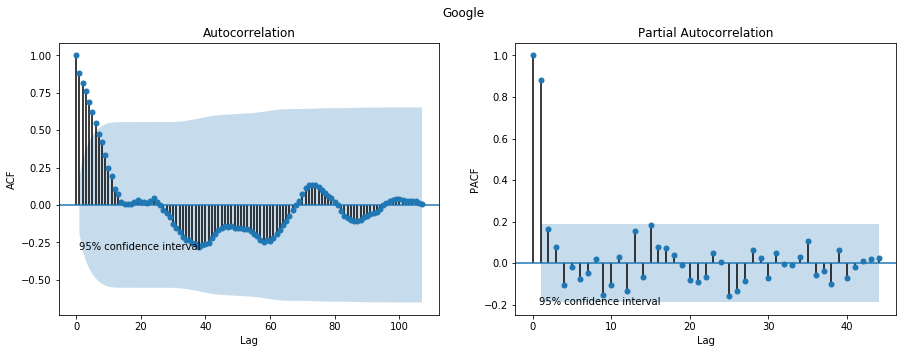

In [50]:
acfpacf(GGL.diff(12).dropna(), "Google")

Google also follows an $AR(2)$ process.

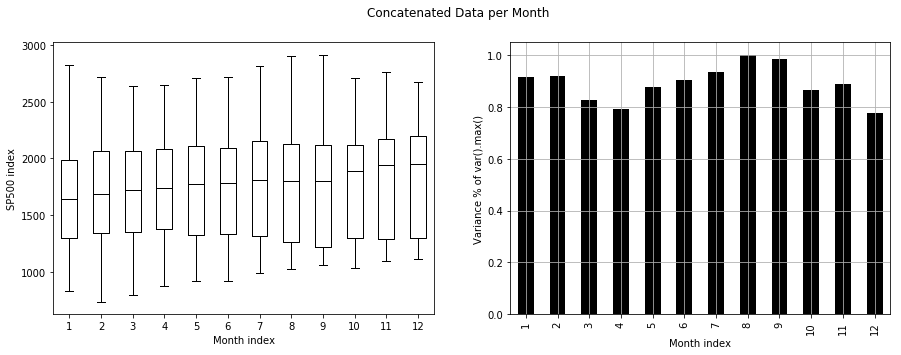

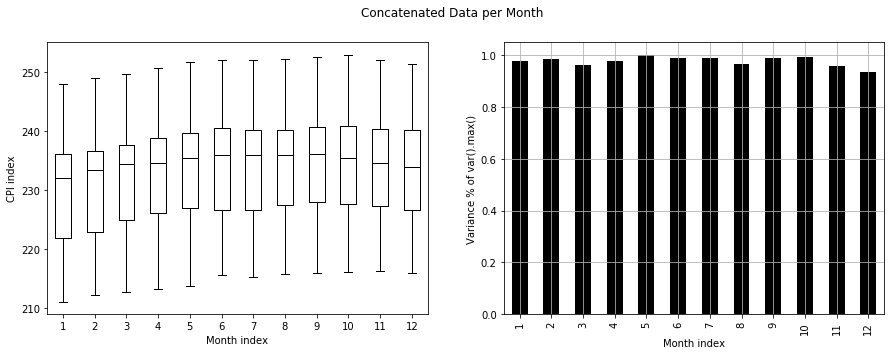

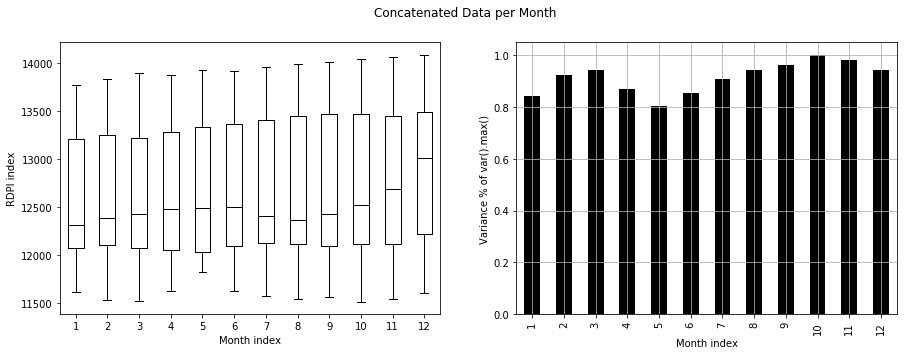

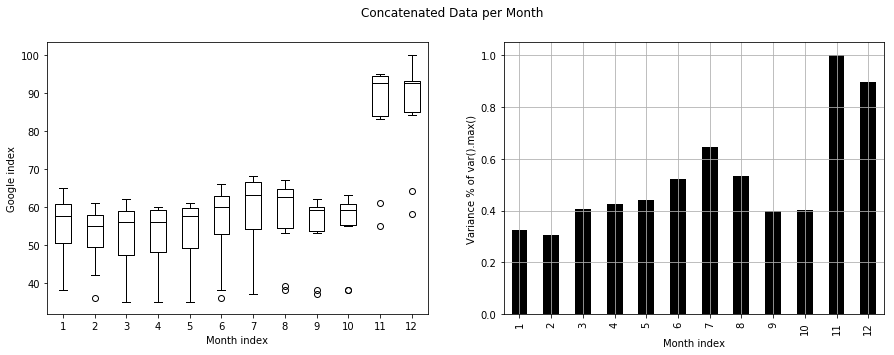

In [17]:
def seasonality_check(DF, Title, key=None, array=None, ):
    """
    data must not include incomplete years. 
    """
    if key and array: #check this line later
        df = data[key][array]
    else:
        df = DF
    mm = [M for M in range(1,13)]
    df_by_month = {}
    for M in mm:
        val = []
        for year in range(len(df)//12):
            val.append(df.iloc[year*12+M-1])
        df_by_month[M] = val
    df_by_month = pd.DataFrame.from_dict(df_by_month)    
    
    fig, axes = plt.subplots(1,2, figsize=(15,5))   
    fig.suptitle("Concatenated Data per Month")
    df_by_month.plot(ax=axes[0], kind="box" , color="k")
    (df_by_month.var()/df_by_month.var().max()).plot(ax=axes[1], kind="bar", grid=True, color="k") # is this normalisation correct?
    axes[0].set(ylabel=f"{Title}", xlabel="Month index")
    axes[1].set(xlabel="Month index", ylabel="Variance % of var().max()")
    return df_by_month


# DJI_by_month = seasonality_check(DJI, "DJI")
SP_by_month = seasonality_check(SP, "SP500 index")
CPI_by_month = seasonality_check(CPI, "CPI index")
RDPI_by_month = seasonality_check(RDPI, "RDPI index")
GGL_by_month = seasonality_check(GGL, "Google index")

$\rightarrow$ seasonal trend seen

# Differencing




## Google

In [4]:
def ADF(array):
    ''' check for unit root errors in dataset'''
    result = adfuller(array)
    print('ADF t-Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] >= 0.05:
        rej = False
    else:
        rej = True
    print("reject H_0:", rej)
    
GGL_log = np.log(GGL) # log transform data
GGL_log_trend = GGL_log.diff(12).dropna() # seasonal differencing YoY
GGL_log_diff = GGL_log_trend.diff(1).dropna() # first order differencing
# GGL_seasonal_diff = GGL.diff(12).dropna()
# GGL_diff = GGL.diff(12).diff(1).dropna()

print("\n GGL_log_trend:")
ADF(GGL_log_trend)
print("\n GGL_log_diff:")
ADF(GGL_log_diff)
print("\n GGL_log_diff2:")
ADF(GGL_log_diff.diff(1).dropna())


 GGL_log_trend:
ADF t-Statistic: -1.663237
p-value: 0.450146
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583
reject H_0: False

 GGL_log_diff:
ADF t-Statistic: -4.775102
p-value: 0.000061
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584
reject H_0: True

 GGL_log_diff2:
ADF t-Statistic: -3.513479
p-value: 0.007648
Critical Values:
	1%: -3.501
	5%: -2.892
	10%: -2.583
reject H_0: True



$\rightarrow$ seasonal D=1 

$\rightarrow$ trend d=1

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


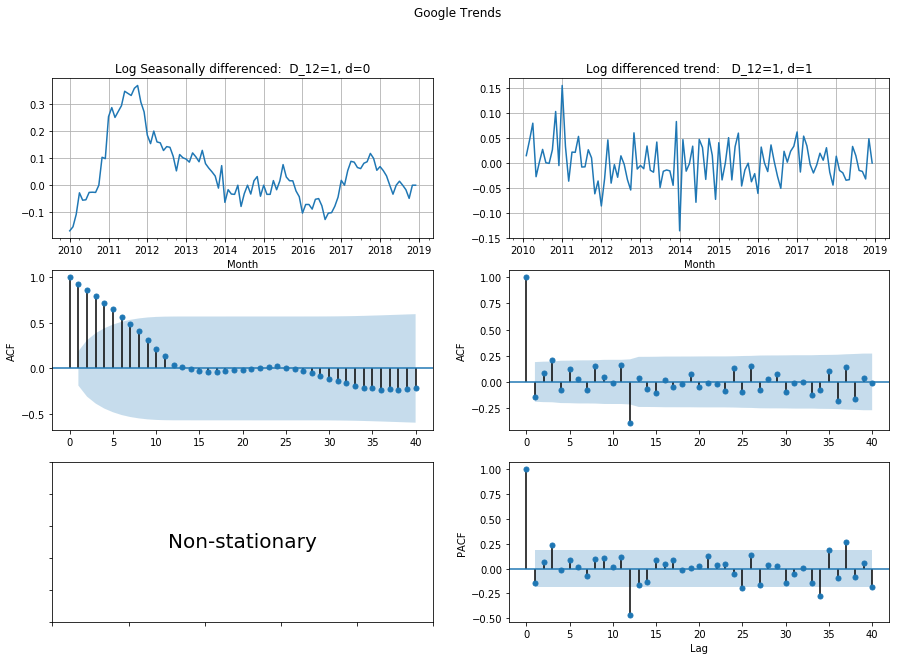

In [27]:
def diff_plots(diff1, diff2, Title="", Title1="Log Seasonally differenced:  D_12=1, d=0", Title2="Log differenced trend:   D_12=1, d=1", lag=40, txt=True, savefig=False):
    fig, axes = plt.subplots(3,2, figsize=[15,10])
    fig.suptitle(Title)
    diff1.plot(ax=axes[0,0], grid=True, title=Title1)
    plot_acf(diff1, ax=axes[1,0], title="", lags=lag);
    axes[1,0].set(ylabel="ACF")
    temp = pacf(GGL_log_diff, nlags=100).max()
    
    # following block doesnt work
    if temp <= 1 and txt==False:
        plot_pacf(diff1, method="ywunbiased", ax=axes[2,0], title="", lags=lag);
        axes[2,0].set(ylabel="PACF", xlabel="Lag")
    elif txt==True:
        axes[2,0].text(.5,.5,"Non-stationary",horizontalalignment='center', verticalalignment='center', fontsize=20)
        axes[2, 0].xaxis.set_ticklabels([])
        axes[2, 0].yaxis.set_ticklabels([])
    else:
        pass
    
    diff2.plot(ax=axes[0,1], grid=True, title=Title2)
    plot_acf(diff2, ax=axes[1,1], title="", lags=lag);
    axes[1,1].set(ylabel="ACF")
    plot_pacf(diff2, method="ywunbiased", ax=axes[2,1], title="", lags=lag);
    axes[2,1].set(ylabel="PACF", xlabel="Lag")
    
    if savefig==True:
        fig.savefig("%s\%s.png" %(save_PATH, Title))
    else: pass

diff_plots(GGL_log_trend, GGL_log_diff, Title="Google Trends")


In [ ]:
# t-test written incorrectly and needs to be fixed

def CF_student_t(data, ACF=False):
    if ACF == False:
        CF = pacf(data, nlags=len(data), method="ywmle")
    else:
        CF = acf(data, nlags=len(data))

    mu = CF.mean()
    std = CF.std()

    t_stat = []
    for i in range(len(CF)):
        rho = CF[i]
        nom = (rho*np.sqrt(len(CF)-2))
        denom = (np.sqrt(1-rho**2))
        
        if denom == 0:
            pass
        else:
            t_stat.append(nom/denom)
    counter = 0
    for t in t_stat:
        if t<4.86:
            counter+=1
        else:
            pass
    print(f"{counter} lags are significant")
    

print("SP PACF:")
CF_student_t(SP)
print("SP ACF:")
CF_student_t(SP, ACF=True)


## SP500

In [6]:
def coolplot(data, supTitle, Title="", pacfmethod="ywunbiased", savefig=False):
    fig = plt.figure(figsize=[15,10])
    fig.suptitle(supTitle)
    grid = plt.GridSpec(3,2,wspace=0.3, hspace=0.4)
    
    ax1 = plt.subplot(grid[0,0])
    data.plot(ax=ax1, grid=True)
    ax1.set(title=Title)
    plt.hlines(y=data.mean(), xmin="2009-01-01", xmax="2018-12-01", color="r")
    
    ax2 = plt.subplot(grid[1,0])
    plot_acf(data, ax=ax2, lags=40)
    ax2.set(ylabel="ACF", xlabel="Lag")
    
    ax3 = plt.subplot(grid[1,1])
    plot_pacf(data, ax=ax3, method=pacfmethod, lags=39)
    ax3.set(ylabel="PACF", xlabel="Lag")
    
    ax4 = plt.subplot(grid[0,1])
    (data**2).plot(title=f"{Title} squared returns", grid=True, ax=ax4)
    
    ax5 = plt.subplot(grid[2,0])
    data.plot(kind="hist", ax=ax5)
    ax5.set(xlabel="returns")
#     x = np.linspace(data.min(), data.max(),num=100)
#     plt.plot(x, norm.pdf(x, 1, np.sqrt(1)),color="r")

    
    ax6 = plt.subplot(grid[2,1])
    probplot(data, plot=ax6, rvalue=True)
    ax6.set(title="QQ plot")
    ax6.grid()
    
    stat, p = shapiro(data)
    if p >= 0.05:
        print(" \t %s Normally distributed" %(supTitle))
    else:
        print(" \t %s Not normally distributed" %(supTitle))
        
    print("\n \t Shapiro t-Statistics: %.3f \n \t p-value: %.3f" %(stat, p))

    
    if savefig==True:
        fig.savefig("%s\%s.png" %(save_PATH, Title))
    else: pass
    

ADF t-Statistic: -11.898261
p-value: 0.000000
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
reject H_0: True
 	 SP500 Not normally distributed

 	 Shapiro t-Statistics: 0.974 
 	 p-value: 0.022
ADF t-Statistic: -5.327099
p-value: 0.000005
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582
reject H_0: True
 	 SP500 Not normally distributed

 	 Shapiro t-Statistics: 0.966 
 	 p-value: 0.004


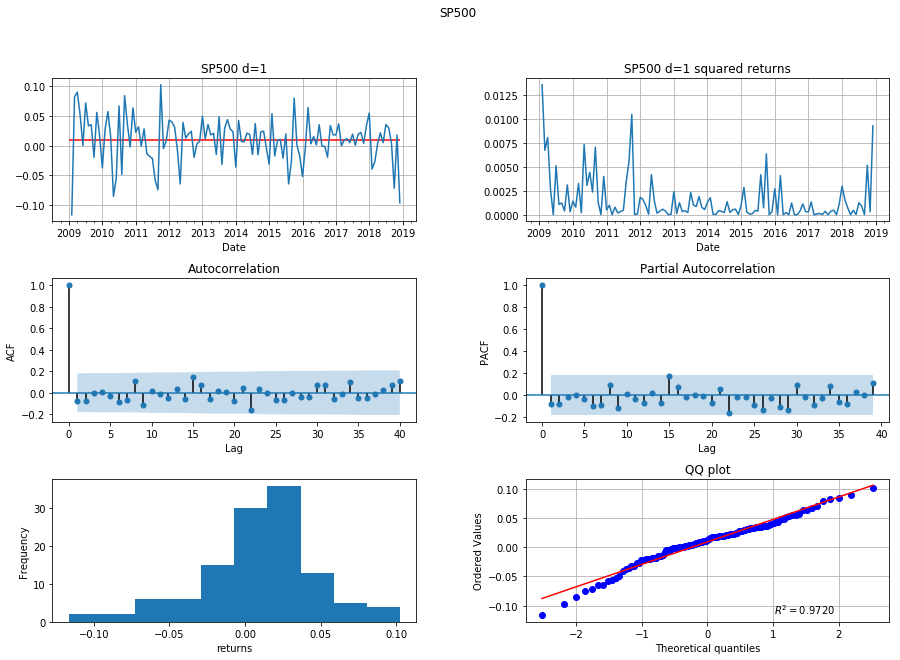

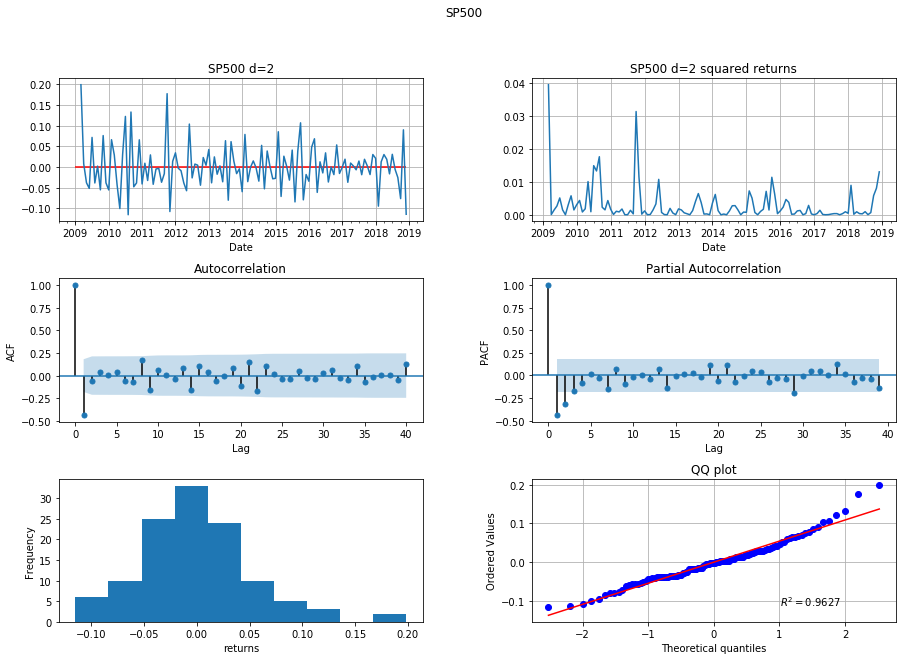

In [7]:
SP_log_diff = np.log(SP).diff(1).dropna()
ADF(SP_log_diff)
coolplot(SP_log_diff, Title="SP500 d=1", supTitle="SP500")

SP_log_diff2 = SP_log_diff.diff(1).dropna()
ADF(SP_log_diff2)
coolplot(SP_log_diff2, Title="SP500 d=2", supTitle="SP500", savefig=True)

$\rightarrow SP = ARIMA(2,1,0)$ or $ARIMA(3,2,1)$

first differencing gives error type 1 on ADF

# RDPI

ADF t-Statistic: -7.232320
p-value: 0.000000
Critical Values:
	1%: -3.490
	5%: -2.888
	10%: -2.581
reject H_0: True
 	 RDPI d=1 Not normally distributed

 	 Shapiro t-Statistics: 0.579 
 	 p-value: 0.000
ADF t-Statistic: -7.479597
p-value: 0.000000
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581
reject H_0: True
 	 RDPI d=2 Not normally distributed

 	 Shapiro t-Statistics: 0.495 
 	 p-value: 0.000


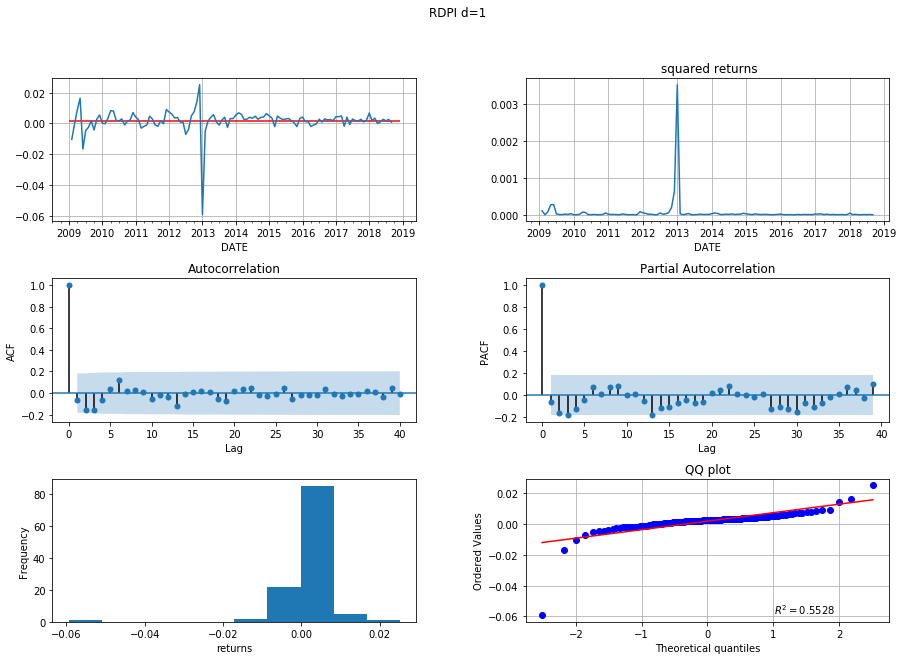

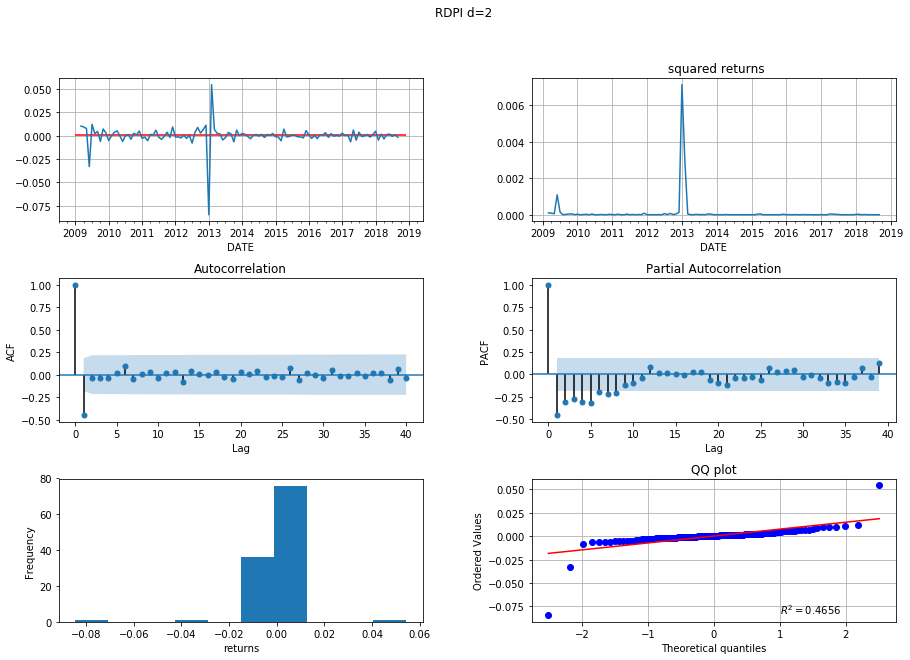

In [12]:
RDPI_log_diff = np.log(RDPI).diff(1).dropna()
ADF(RDPI_log_diff)
coolplot(RDPI_log_diff, "RDPI d=1")

RDPI_log_diff2 = RDPI_log_diff.diff(1).dropna()
ADF(RDPI_log_diff2)
coolplot(RDPI_log_diff2, "RDPI d=2")

ADF t-Statistic: -2.405335
p-value: 0.140236
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581
reject H_0: False
 	 CPI Normally distributed

 	 Shapiro t-Statistics: 0.995 
 	 p-value: 0.948
ADF t-Statistic: -8.066974
p-value: 0.000000
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581
reject H_0: True
 	 CPI Normally distributed

 	 Shapiro t-Statistics: 0.989 
 	 p-value: 0.481


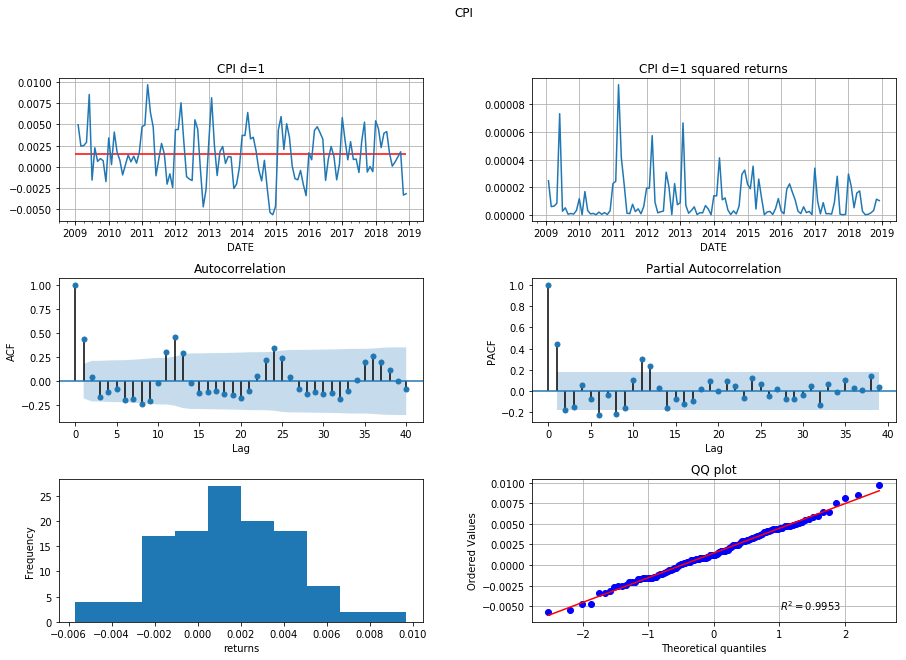

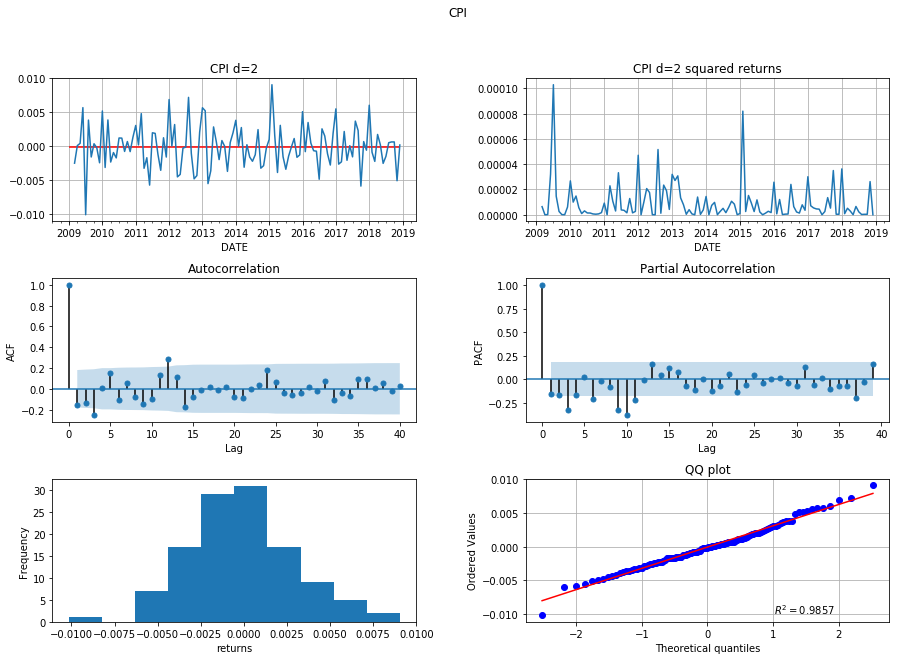

In [13]:
CPI_log_diff = np.log(CPI).diff(1).dropna()
ADF(CPI_log_diff)
coolplot(CPI_log_diff, Title="CPI d=1", supTitle="CPI")

CPI_log_diff2 = CPI_log_diff.diff(1).dropna()
ADF(CPI_log_diff2)
coolplot(CPI_log_diff2, Title="CPI d=2", supTitle="CPI")

RDPI can be estimated with a simple linear regression with error even. Forecast would not be useful. 

# SARIMA(p,d,q)(P,D,Q)$_m$

90% of the data is chosen as a training set and the remainder can be used as an in sample test of the fit.

In [14]:
def test_train(data):
    train, test = np.log(data.iloc[:round(len(data)*0.95)]), np.log(data.iloc[round(len(data)*0.9):])
    return train, test

GGL_train, GGL_test = test_train(GGL)[0], test_train(GGL)[1]
SP_train, SP_test = test_train(SP)[0], test_train(SP)[1]
RDPI_train, RDPI_test = test_train(RDPI)[0], test_train(RDPI)[1]
CPI_train, CPI_test = test_train(CPI)[0], test_train(CPI)[1]


## Google

In [15]:
GGL_model210 = SARIMAX(GGL_train, order=(2,1,0), seasonal_order=(2,1,0,12), simple_differencing=True)
GGL_fit210 = GGL_model210.fit()
GGL_fit210.summary()

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        D.DS12.Top5   No. Observations:                  101
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood                 187.650
Date:                            Sat, 28 Sep 2019   AIC                           -365.300
Time:                                    14:49:17   BIC                           -352.224
Sample:                                02-01-2010   HQIC                          -360.007
                                     - 06-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1187      0.106     -1.124      0.261      -0.326       0.088
ar.L2          0.0408      0.127      0.322      0.748      -0.207       0.289
ar.S.L12      -0.4853      0.106     -4.567      0.000      -0.694      -0.277
ar.S.L24      -0.0413      0.094     -0.439      0.660      -0.225       0.143
sigma2         0.0014      0.000      8.265      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       49.53   Jarque-Bera (JB):                17.15
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.19
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SP500

In [16]:
SP_model321 = SARIMAX(SP_train, order=(3,2,1))
SP_fit321 = SP_model321.fit()
SP_fit321.summary()

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Close   No. Observations:                  114
Model:               SARIMAX(3, 2, 1)   Log Likelihood                 208.472
Date:                Sat, 28 Sep 2019   AIC                           -406.944
Time:                        14:49:18   BIC                           -393.351
Sample:                    01-01-2009   HQIC                          -401.429
                         - 06-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0987      0.077     -1.284      0.199      -0.250       0.052
ar.L2         -0.1444      0.097     -1.495      0.135      -0.334       0.045
ar.L3         -0.0006      0.091     -0.006      0.995      -0.179       0.178
ma.L1         -0.9813      0.070    -14.069      0.000      -1.118      -0.845
sigma2         0.0014      0.000      9.474      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       25.88   Jarque-Bera (JB):                10.61
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## RDPI

In [17]:
RDPI_model128 = SARIMAX(RDPI_train, order=(1,2,8))
RDPI_fit128 = RDPI_model128.fit()
RDPI_fit128.summary()

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                DSPIC96   No. Observations:                  111
Model:               SARIMAX(1, 2, 8)   Log Likelihood                 381.870
Date:                Sat, 28 Sep 2019   AIC                           -743.741
Time:                        14:49:20   BIC                           -716.827
Sample:                    01-01-2009   HQIC                          -732.826
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2528      1.454     -0.174      0.862      -3.103       2.597
ma.L1         -0.8669      1.470     -0.590      0.555      -3.748       2.014
ma.L2         -0.3490      1.674     -0.208      0.835      -3.630       2.932
ma.L3          0.0582      0.183      0.317      0.751      -0.301       0.418
ma.L4          0.1736      0.227      0.764      0.445      -0.272       0.619
ma.L5          0.1787      0.369      0.484      0.629      -0.545       0.903
ma.L6          0.1396      0.250      0.559      0.576      -0.350       0.629
ma.L7         -0.1506      0.165     -0.913      0.361      -0.474       0.173
ma.L8         -0.1540      0.341     -0.451      0.652      -0.823       0.515
sigma2      5.095e-05   6.82e-06      7.469      0.000    3.76e-05    6.43e-05
===================================================================================
Ljung-Box (Q):                        9.68   Jarque-Bera (JB):              2759.40
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# CPI

In [18]:
RDPI_model3111 = SARIMAX(RDPI_train, order=(3,1,11))
RDPI_fit3111 = RDPI_model3111.fit()
RDPI_fit3111.summary()

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                DSPIC96   No. Observations:                  111
Model:              SARIMAX(3, 1, 11)   Log Likelihood                 386.409
Date:                Sat, 28 Sep 2019   AIC                           -742.817
Time:                        14:49:21   BIC                           -702.310
Sample:                    01-01-2009   HQIC                          -726.388
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5662      8.791      0.064      0.949     -16.665      17.797
ar.L2          0.0115      5.634      0.002      0.998     -11.030      11.053
ar.L3          0.1326      4.107      0.032      0.974      -7.917       8.182
ma.L1         -0.6665      8.792     -0.076      0.940     -17.898      16.565
ma.L2         -0.1021      6.341     -0.016      0.987     -12.530      12.325
ma.L3         -0.1420      4.855     -0.029      0.977      -9.658       9.374
ma.L4          0.1010      0.683      0.148      0.882      -1.238       1.440
ma.L5          0.1598      1.379      0.116      0.908      -2.543       2.862
ma.L6          0.1733      1.533      0.113      0.910      -2.831       3.177
ma.L7         -0.0191      1.545     -0.012      0.990      -3.048       3.009
ma.L8          0.0116      1.069      0.011      0.991      -2.084       2.108
ma.L9         -0.0318      0.853     -0.037      0.970      -1.704       1.640
ma.L10        -0.0798      0.585     -0.136      0.891      -1.227       1.067
ma.L11         0.0126      0.899      0.014      0.989      -1.750       1.775
sigma2      5.121e-05   6.11e-06      8.381      0.000    3.92e-05    6.32e-05
===================================================================================
Ljung-Box (Q):                        9.74   Jarque-Bera (JB):              3587.87
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -3.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# AIC, BIC, optimisation

Here we also check to see if there is overfitting etc (in sample forecast)

In [19]:
def optimise_SARIMAX(data, maxpdq, minpdq=(1,1,1), maxPDQ=(0,0,0,0)):
    ''' iterates through p and q and outputs best AIC, BIC, HQIC order fits'''
    tests = ["AIC", "BIC", "HQIC"]
    results = {}

    for p in range(minpdq[0],maxpdq[0]+1):
        for q in range(minpdq[0],maxpdq[2]+1):
            if sum(maxPDQ) != 0:
                for P in range(1, maxPDQ[0]+1):
                    for Q in range(1, maxPDQ[2]+1):
                        pdqorder=(p,maxpdq[1],q)
                        PDQOrder = (P, maxPDQ[1], Q, maxPDQ[3])
                        order_Order=(pdqorder,PDQOrder)
                        print(f" order: {order_Order}")
                        mod_fit = SARIMAX(data, order=(p,maxpdq[1],q), seasonal_order=(P,maxPDQ[1],Q,maxPDQ[3]),enforce_invertibility=False).fit()
                        AIC = mod_fit.aic
                        BIC = mod_fit.bic
                        HQIC = mod_fit.hqic
                        results[order_Order] = (AIC,BIC,HQIC)                        
            else:
                pdqorder = (p,maxpdq[1],q)
                print(f"order: {pdqorder}")
                mod_fit = SARIMAX(data, order=pdqorder,enforce_invertibility=False).fit()
                AIC = mod_fit.aic
                BIC = mod_fit.bic
                HQIC = mod_fit.hqic
                results[pdqorder] = (AIC,BIC,HQIC)
    results = pd.DataFrame(results, index=tests).T
    print("\n")
# choose minimum
    for i in range(len(tests)):
        print(f"{tests[i]} minimised at: \n", results[tests[i]][results[tests[i]]==results[tests[i]].min()])
    return results

In [20]:
def forcplot(modelfit, data=None, horizon=12, Start="2015-01-01", Label=""):
    forc = modelfit.get_forecast(horizon)
    pred = modelfit.get_prediction(start=Start)
    
    pred_low_conf_int,pred_up_conf_int = pred.conf_int().iloc[:,0],pred.conf_int().iloc[:,1]
    forc_low_conf_int,forc_up_conf_int = forc.conf_int().iloc[:,0],forc.conf_int().iloc[:,1]

    lower = pd.concat([pred_low_conf_int, forc_low_conf_int])
    upper = pd.concat([pred_up_conf_int, forc_up_conf_int])
    
    fig, ax = plt.subplots()
    data.loc[Start:].plot(ax=ax, label="observation", color="k")
    np.exp(pred.predicted_mean).plot(ax=ax, label=f"{Label} (In Sample)", color="c")
    xs = lower.keys()
    ax.fill_between(xs,np.exp(lower), np.exp(upper), color="0.9", label="95% confidence interval")
    np.exp(forc.predicted_mean).plot(ax=ax, label=f"{Label}", color="r")
    plt.grid()
    plt.ylabel("Index value")
    plt.legend()

# SP

In [77]:
optimise_SARIMAX(SP_train, maxpdq=(4,2,2))

order: (1, 2, 1)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (1, 2, 2)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 2, 1)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 2, 2)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 2, 1)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 2, 2)
order: (4, 2, 1)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (4, 2, 2)


AIC minimised at: 
 2  2  1   -409.012868
Name: AIC, dtype: float64
BIC minimised at: 
 1  2  1   -400.760289
Name: BIC, dtype: float64
HQIC minimised at: 
 1  2  1   -405.606842
Name: HQIC, dtype: float64


AIC         BIC        HQIC
1 2 1 -408.915786 -400.760289 -405.606842
    2 -406.328201 -395.454206 -401.916275
2 2 1 -409.012868 -398.138873 -404.600942
    2 -405.497535 -391.905041 -399.982628
3 2 1 -406.943688 -393.351194 -401.428781
    2 -405.102154 -388.791161 -398.484266
4 2 1 -404.859220 -388.548227 -398.241331
    2 -403.097109 -384.067617 -395.376239

In [299]:
SP_SARIMAX_fit121 = SARIMAX(SP_train, order=(1,2,1),enforce_invertibility=False).fit()
SP_SARIMAX_fit121_inSample = SP_SARIMAX_fit121.predict(start="2015-01-01")
SP_SARIMAX_fit121_forecast = SP_SARIMAX_fit121.forecast(12)

SP_SARIMAX_fit212 = SARIMAX(SP_train, order=(2,1,2),enforce_invertibility=False).fit()
SP_SARIMAX_fit212_inSample = SP_SARIMAX_fit212.predict(start="2015-01-01")
SP_SARIMAX_fit212_forecast = SP_SARIMAX_fit212.forecast(12)

SP_SARIMAX_fit321 = SARIMAX(SP_train, order=(3,2,1),enforce_invertibility=False).fit()
SP_SARIMAX_fit321_inSample = SP_SARIMAX_fit311.predict(start="2015-01-01")
SP_SARIMAX_fit321_forecast = SP_SARIMAX_fit311.forecast(12)

print(SP_SARIMAX_fit121.summary()) #2
print(SP_SARIMAX_fit321.summary()) #3 

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                  114
Model:               SARIMAX(1, 2, 1)   Log Likelihood                 207.562
Date:                Fri, 05 Apr 2019   AIC                           -409.124
Time:                        02:17:18   BIC                           -400.968
Sample:                    01-01-2009   HQIC                          -405.815
                         - 06-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0846      0.072     -1.170      0.242      -0.226       0.057
ma.L1         -1.0000     69.785     -0.014      0.989    -137.776     135.777
sigma2         0.0014      0.096      0.014      0.9

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [361]:
SP_SARIMAX_fit212.summary() #1 best model


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Close   No. Observations:                  114
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 211.083
Date:                Fri, 05 Apr 2019   AIC                           -412.166
Time:                        05:12:34   BIC                           -398.529
Sample:                    01-01-2009   HQIC                          -406.632
                         - 06-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0561      0.085      0.656      0.512      -0.111       0.224
ar.L2          0.9430      0.083     11.339      0.000       0.780       1.106
ma.L1          0.0076     18.672      0.000      1.000     -36.588      36.604
ma.L2         -0.9923     18.496     -0.054      0.957     -37.244      35.260
sigma2         0.0014      0.025      0.054      0.957      -0.048       0.051
===================================================================================
Ljung-Box (Q):                       28.82   Jarque-Bera (JB):                 2.52
Prob(Q):                              0.91   Prob(JB):                         0.28
Heteroskedasticity (H):               0.30   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [384]:
SP_SARIMAX_fit212.resid.mean()

0.060511505157194265

In [370]:
SP_SARIMAX_fit2115 = SARIMAX(SP_train, order=(2,2,15),enforce_invertibility=False).fit()
SP_SARIMAX_fit2115_inSample = SP_SARIMAX_fit2115.predict(start="2015-01-01")
SP_SARIMAX_fit2115_forecast = SP_SARIMAX_fit2115.forecast(12)
SP_SARIMAX_fit2115.summary()

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Close   No. Observations:                  114
Model:              SARIMAX(2, 2, 15)   Log Likelihood                 211.742
Date:                Fri, 05 Apr 2019   AIC                           -387.484
Time:                        05:18:55   BIC                           -338.551
Sample:                    01-01-2009   HQIC                          -367.631
                         - 06-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8212      1.364     -0.602      0.547      -3.494       1.852
ar.L2         -0.3179      1.088     -0.292      0.770      -2.450       1.815
ma.L1         -0.3587      1.649     -0.218      0.828      -3.591       2.873
ma.L2         -0.6904      1.224     -0.564      0.573      -3.089       1.709
ma.L3         -0.2529      1.343     -0.188      0.851      -2.886       2.380
ma.L4          0.1825      0.436      0.419      0.675      -0.671       1.036
ma.L5          0.0367      0.349      0.105      0.916      -0.648       0.721
ma.L6         -0.1710      0.181     -0.946      0.344      -0.525       0.183
ma.L7         -0.0790      0.421     -0.187      0.851      -0.905       0.747
ma.L8          0.1839      0.372      0.495      0.621      -0.544       0.912
ma.L9          0.0135      0.404      0.033      0.973      -0.778       0.805
ma.L10        -0.0404      0.202     -0.200      0.841      -0.436       0.355
ma.L11         0.0043      0.238      0.018      0.986      -0.463       0.471
ma.L12         0.0208      0.230      0.091      0.928      -0.430       0.472
ma.L13         0.1183      0.197      0.601      0.548      -0.267       0.504
ma.L14        -0.0756      0.248     -0.305      0.760      -0.561       0.410
ma.L15         0.0854      0.176      0.486      0.627      -0.259       0.430
sigma2         0.0011      0.001      0.861      0.389      -0.001       0.004
===================================================================================
Ljung-Box (Q):                       20.19   Jarque-Bera (JB):                11.16
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

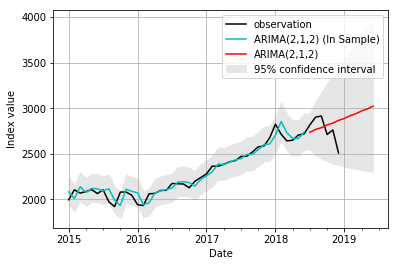

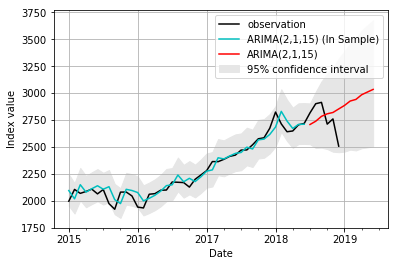

In [371]:
# forcplot(SP_SARIMAX_fit121, data=SP, Label="ARIMA(1,2,1)")
forcplot(SP_SARIMAX_fit212, data=SP, Label="ARIMA(2,1,2)")
forcplot(SP_SARIMAX_fit2115, data=SP, Label="ARIMA(2,1,15)")

In [ ]:
DJI_fit_tests = optimise_SARIMAX(DJI_train, maxpdq=(4,2,2))
DJI_fit_tests

In [ ]:
DJI_model_fit = SARIMAX(SP_train, order=(2,2,1)).fit()
DJI_SARIMAX_forecast = DJI_model_fit.predict(start="2017-02-01", end="2018-12-01")

fig, axes = plt.subplots()
DJI_train.loc["2017-01-01":].plot(ax=axes, label="SP500")
np.exp(DJI_SARIMAX_forecast).plot(ax=axes, label="forecast")
axes.legend()
axes.grid()

# RDPI

In [363]:
optimise_SARIMAX(RDPI_train, maxpdq=(3,2,10))

order: (1, 2, 1)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (1, 2, 2)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (1, 2, 3)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (1, 2, 4)
order: (1, 2, 5)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (1, 2, 6)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (1, 2, 7)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (1, 2, 8)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (1, 2, 9)
order: (1, 2, 10)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 2, 1)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 2, 2)
order: (2, 2, 3)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 2, 4)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 2, 5)
order: (2, 2, 6)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 2, 7)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 2, 8)
order: (2, 2, 9)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 2, 10)
order: (3, 2, 1)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 2, 2)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 2, 3)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 2, 4)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 2, 5)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 2, 6)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 2, 7)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 2, 8)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 2, 9)
order: (3, 2, 10)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)




AIC minimised at: 
 3  2  1   -748.310193
Name: AIC, dtype: float64
BIC minimised at: 
 1  2  1   -738.359597
Name: BIC, dtype: float64
HQIC minimised at: 
 1  2  1   -743.159321
Name: HQIC, dtype: float64


AIC         BIC        HQIC
1 2 1  -746.433641 -738.359597 -743.159321
    2  -744.145741 -733.380350 -739.779982
    3  -743.806283 -730.349543 -738.349083
    4  -746.089625 -729.941538 -739.540986
    5  -744.217590 -725.378155 -736.577511
    6  -742.220712 -720.689928 -733.489193
    7  -742.371877 -718.149746 -732.548918
    8  -744.317190 -717.403711 -733.402791
    9  -742.710886 -713.106060 -730.705048
    10 -740.593925 -708.297751 -727.496647
2 2 1  -746.982747 -736.217356 -742.616988
    2  -743.176175 -729.719435 -737.718975
    3  -740.311140 -724.163053 -733.762501
    4  -744.354310 -725.514875 -736.714231
    5  -742.724048 -721.193265 -733.992529
    6  -740.542452 -716.320321 -730.719493
    7  -743.780730 -716.867251 -732.866331
    8  -741.338896 -711.734069 -729.333058
    9  -740.569766 -708.273592 -727.472488
    10 -739.032450 -704.044927 -724.843732
3 2 1  -748.310193 -734.853454 -742.852994
    2  -744.709892 -728.561804 -738.161252
    3  -739.725877 -720.886442 -732.085798
    4  -741.359033 -719.828250 -732.627514
    5  -740.309064 -716.086934 -730.486106
    6  -738.665600 -711.752121 -727.751202
    7  -741.543868 -711.939042 -729.538030
    8  -739.313055 -707.016880 -726.215776
    9  -738.577318 -703.589796 -724.388600
    10 -736.996447 -699.317577 -721.716289

In [364]:
RDPI_SARIMAX_fit110 = SARIMAX(RDPI_train, order=(1,1,0)).fit()
RDPI_SARIMAX_fit110.summary()

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                DSPIC96   No. Observations:                  111
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 379.158
Date:                Fri, 05 Apr 2019   AIC                           -754.315
Time:                        05:16:05   BIC                           -748.914
Sample:                    01-01-2009   HQIC                          -752.125
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0021      0.077      0.027      0.978      -0.149       0.154
sigma2      5.935e-05   4.12e-06     14.412      0.000    5.13e-05    6.74e-05
===================================================================================
Ljung-Box (Q):                       14.74   Jarque-Bera (JB):              7458.20
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -4.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
RDPI_SARIMAX_fit321 = SARIMAX(RDPI_train, order=(3,2,1)).fit()
RDPI_SARIMAX_fit121 = SARIMAX(RDPI_train, order=(1,2,1)).fit()

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


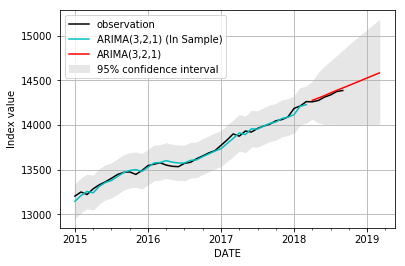

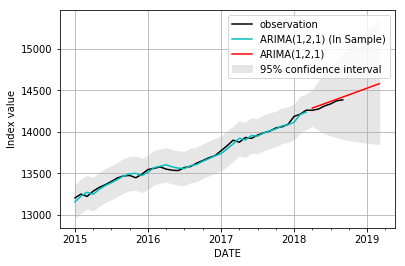

In [215]:
forcplot(RDPI_SARIMAX_fit321, data=RDPI, Label="ARIMA(3,2,1)")
forcplot(RDPI_SARIMAX_fit121, data=RDPI, Label="ARIMA(1,2,1)")

# CPI

In [216]:
optimise_SARIMAX(CPI_train, maxpdq=(3,1,4))

order: (1, 1, 1)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (1, 1, 2)
order: (1, 1, 3)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (1, 1, 4)
order: (2, 1, 1)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 1, 2)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 1, 3)
order: (2, 1, 4)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 1, 1)
order: (3, 1, 2)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 1, 3)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 1, 4)


AIC minimised at: 
 1  1  2   -1004.088372
Name: AIC, dtype: float64
BIC minimised at: 
 1  1  1   -995.257652
Name: BIC, dtype: float64
HQIC minimised at: 
 1  1  1   -1000.119579
Name: HQIC, dtype: float64


AIC         BIC         HQIC
1 1 1 -1003.439816 -995.257652 -1000.119579
    2 -1004.088372 -993.178821  -999.661390
    3 -1000.989071 -987.352132  -995.455343
    4  -998.600727 -982.236400  -991.960253
2 1 1  -999.746880 -988.837329  -995.319898
    2 -1001.105144 -987.468205  -995.571416
    3  -998.241170 -981.876843  -991.600697
    4  -997.561726 -978.470011  -989.814507
3 1 1 -1000.391957 -986.755018  -994.858229
    2 -1000.568081 -984.203754  -993.927607
    3  -998.842080 -979.750365  -991.094861
    4  -999.419615 -977.600512  -990.565650

In [97]:
CPI_SARIMAX_fit11 = SARIMAX(CPI_train, order=(1,1,1)).fit()

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


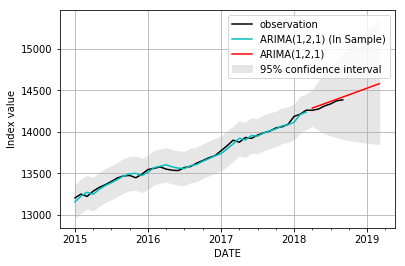

In [217]:
forcplot(RDPI_SARIMAX_fit121, data=RDPI, Label="ARIMA(1,2,1)")

# Google

In [101]:
GGL_fit_tests = optimise_SARIMAX(GGL_train, maxpdq=(2,2,2), maxPDQ=(2,1,2,12))
GGL_fit_tests


 order: ((1, 2, 1), (1, 1, 1, 12))


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 order: ((1, 2, 1), (1, 1, 2, 12))


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 order: ((1, 2, 1), (2, 1, 1, 12))
 order: ((1, 2, 1), (2, 1, 2, 12))


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 order: ((1, 2, 2), (1, 1, 1, 12))
 order: ((1, 2, 2), (1, 1, 2, 12))


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 order: ((1, 2, 2), (2, 1, 1, 12))


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 order: ((1, 2, 2), (2, 1, 2, 12))


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 order: ((2, 2, 1), (1, 1, 1, 12))
 order: ((2, 2, 1), (1, 1, 2, 12))


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 order: ((2, 2, 1), (2, 1, 1, 12))


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 order: ((2, 2, 1), (2, 1, 2, 12))


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 order: ((2, 2, 2), (1, 1, 1, 12))


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 order: ((2, 2, 2), (1, 1, 2, 12))


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 order: ((2, 2, 2), (2, 1, 1, 12))


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


 order: ((2, 2, 2), (2, 1, 2, 12))


AIC minimised at: 
 (1, 2, 1)  (1, 1, 1, 12)   -359.952016
Name: AIC, dtype: float64
BIC minimised at: 
 (1, 2, 1)  (1, 1, 1, 12)   -346.926165
Name: BIC, dtype: float64
HQIC minimised at: 
 (1, 2, 1)  (1, 1, 1, 12)   -354.68022
Name: HQIC, dtype: float64


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC         BIC        HQIC
(1, 2, 1) (1, 1, 1, 12) -359.952016 -346.926165 -354.680220
          (1, 1, 2, 12) -359.287873 -343.656852 -352.961718
          (2, 1, 1, 12) -358.309670 -342.678649 -351.983514
          (2, 1, 2, 12) -357.773286 -339.537095 -350.392772
(1, 2, 2) (1, 1, 1, 12) -358.568822 -342.937801 -352.242667
          (1, 1, 2, 12) -358.002599 -339.766408 -350.622085
          (2, 1, 1, 12) -356.827638 -338.591446 -349.447123
          (2, 1, 2, 12) -356.351497 -335.510136 -347.916623
(2, 2, 1) (1, 1, 1, 12) -359.460917 -343.829896 -353.134761
          (1, 1, 2, 12) -357.753252 -339.517061 -350.372737
          (2, 1, 1, 12) -358.023264 -339.787073 -350.642749
          (2, 1, 2, 12) -357.286614 -336.445253 -348.851740
(2, 2, 2) (1, 1, 1, 12) -358.831806 -340.595614 -351.451291
          (1, 1, 2, 12) -357.655370 -336.814009 -349.220496
          (2, 1, 1, 12) -357.499715 -336.658353 -349.064841
          (2, 1, 2, 12) -356.942554 -333.496022 -347.453321

In [125]:
GGL_SARIMAX_fit121 = SARIMAX(GGL_train, order=(1,2,1), seasonal_order=(1,1,1,12)).fit()
GGL_SARIMAX_fit121.summary()

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               Top5   No. Observations:                  114
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood                 184.975
Date:                            Fri, 05 Apr 2019   AIC                           -359.950
Time:                                    00:29:52   BIC                           -346.924
Sample:                                01-01-2009   HQIC                          -354.678
                                     - 06-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2383      0.110     -2.157      0.031      -0.455      -0.022
ma.L1         -0.8599      0.066    -13.001      0.000      -0.990      -0.730
ar.S.L12      -0.3636      0.181     -2.010      0.044      -0.718      -0.009
ma.S.L12      -0.1332      0.204     -0.654      0.513      -0.532       0.266
sigma2         0.0014      0.000      7.467      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       42.07   Jarque-Bera (JB):                 3.53
Prob(Q):                              0.38   Prob(JB):                         0.17
Heteroskedasticity (H):               0.59   Skew:                             0.26
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

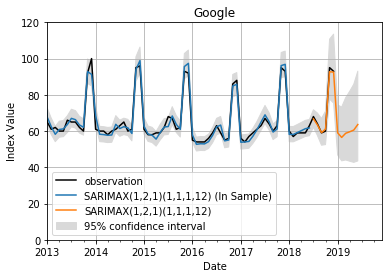

In [218]:
pred = GGL_SARIMAX_fit121.get_prediction()
forc = GGL_SARIMAX_fit121.get_forecast(12)

pred_low_conf_int,pred_up_conf_int = pred.conf_int().iloc[:,0],pred.conf_int().iloc[:,1]
forc_low_conf_int,forc_up_conf_int = forc.conf_int().iloc[:,0],forc.conf_int().iloc[:,1]
lower = pd.concat([pred_low_conf_int, forc_low_conf_int])
upper = pd.concat([pred_up_conf_int, forc_up_conf_int])
xs = lower.keys()

fig, ax = plt.subplots()
GGL.plot(ax=ax, color="k", label="observation")
# fit prediction
np.exp(pred.predicted_mean).plot(ax=ax, label="SARIMAX(1,2,1)(1,1,1,12) (In Sample)")
# forecast
np.exp(forc.predicted_mean).plot(ax=ax, label="SARIMAX(1,2,1)(1,1,1,12)")
plt.fill_between(xs,np.exp(lower),np.exp(upper), color="0.85", label="95% confidence interval")

ax.set(xlabel="Date", ylabel="Index Value", title="Google")
plt.ylim([0,120])
plt.xlim(["2013-01-01","2019-12-01"])
plt.grid()
plt.legend()

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(734869.0, 736846.0)

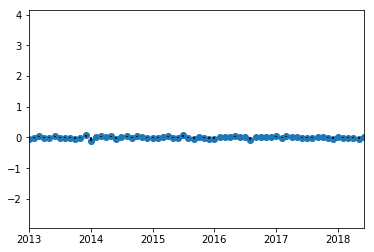

In [382]:
GGL_SARIMAX_fit121 = SARIMAX(GGL_train, order=(1,2,1), seasonal_order=(1,1,1,12)).fit()
plt.scatter(GGL_SARIMAX_fit121.resid.keys(), GGL_SARIMAX_fit121.resid)
plt.vlines(GGL_SARIMAX_fit121.resid.keys(),0,GGL_SARIMAX_fit121.resid)
plt.xlim(["2013-01-01","2018-06-01"])

# GARCH(p,q)

#### Heteroskedacticity



In [ ]:



# Levene test (null says equal variance) cant use because data is not normal
# from scipy.stats import levene

# which function to use in the test
# ‘median’ : Recommended for skewed (non-normal) distributions>
# ‘mean’ : Recommended for symmetric, moderate-tailed distributions.
# ‘trimmed’ : Recommended for heavy-tailed distributions.
# def lev(data):
#     Levene = levene(data[len(data)//2:], data[:len(data//2)], center="trimmed")
#     print("Levene Test:")
#     print("\tstatistic=", Levene[0])
#     print("\tp-value=", Levene[1])
#     # with alpha = 0.05, if F>1.9855 regect null (sigma_1=sigma_2=...=sigma_p)
#     if Levene[1] <= 0.5:
#         rej = True
#     else:
#         rej = False
#     print("reject H_0:", rej)
    
# lev(GGL.diff(1).dropna())
# lev(SP.diff(1).dropna())
# lev(DJI.diff(1).dropna())

#Breusch Pagan Test
# from statsmodels.stats.diagnostic import het_breuschpagan
# from statsmodels.formula.api import ols



#Score Test

# F-test


[Text(0,0.5,'var(GGL)'), Text(0.5,0,'Year index')]

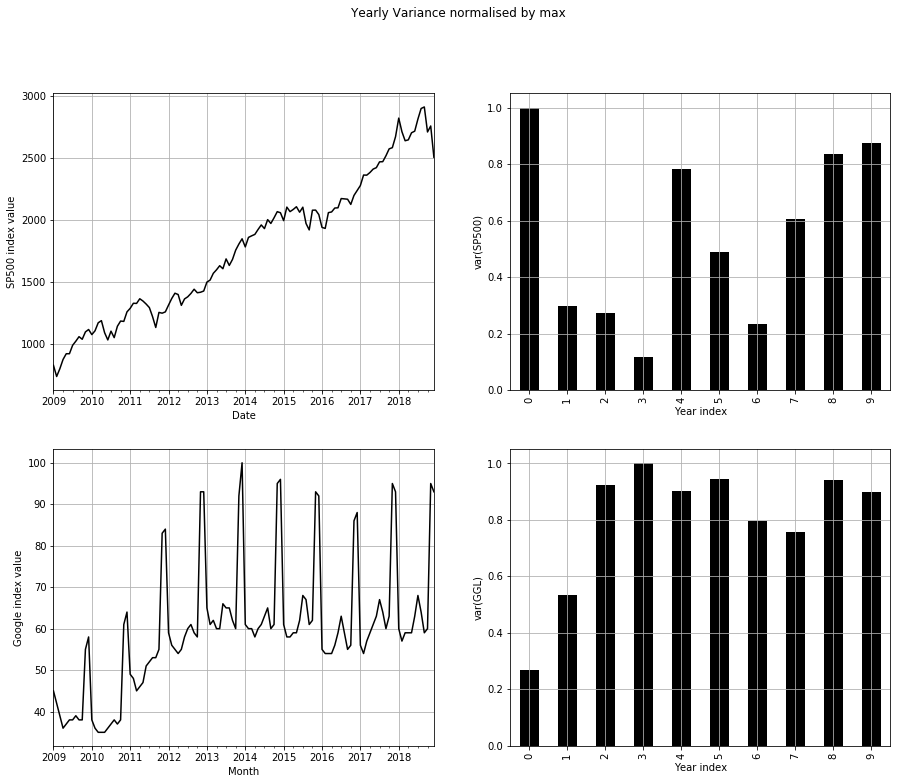

In [227]:
def var_growth_check(df):
    df_years = {}
    mm = [M for M in range(12)]
    for year in range(len(df)//12):
        val = []
        for M in mm:
            val.append(df.iloc[year*12+M])
        df_years[year] = val
    df_years = pd.DataFrame.from_dict(df_years)
    return df_years

# DJI_year_var = var_growth_check(DJI)
SP_year_var = var_growth_check(SP)
GGL_year_var = var_growth_check(GGL)

fig, axes = plt.subplots(2,2,figsize=(15,12))
fig.suptitle("Yearly Variance normalised by max")


SP.plot(ax=axes[0, 0], grid=True, color="k")
axes[0,0].set(ylabel="SP500 index value", xlim=["2009-01-01" , "2018-12-01"])
(SP_year_var.var()/SP_year_var.var().max()).plot(ax=axes[0, 1],grid=True, color="k", kind="bar")# is this normalisationcorrect
axes[0, 1].set(xlabel="Year index", ylabel="var(SP500)")

GGL.plot(ax=axes[1,0], grid=True, color="k")
axes[1,0].set(ylabel="Google index value", xlim=["2009-01-01" , "2018-12-01"])
(GGL_year_var.var()/GGL_year_var.var().max()).plot(ax=axes[1,1], grid=True, color="k", kind="bar")
axes[1, 1].set(xlabel="Year index", ylabel="var(GGL)")


Text(0,-0.2,'95% confidence interval')

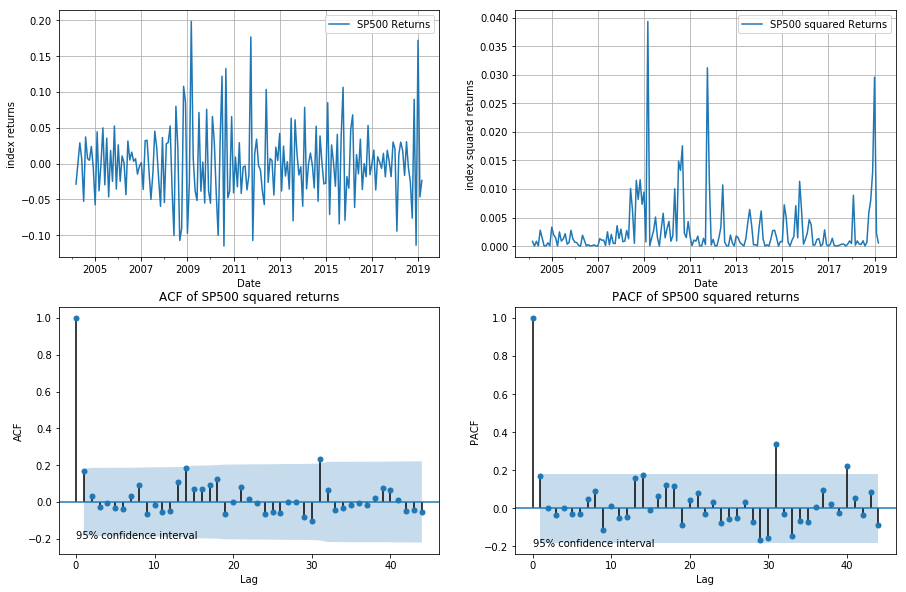

In [8]:
SP_log_diff2 = pd.DataFrame(SP_log_diff2)

fig, ax = plt.subplots(2,2, figsize=[15,10])
((np.log(data["SP500"]["Close"]).diff(1).diff(1))).dropna().plot(ax=ax[0,0], label="SP500 Returns")
ax[0,0].grid()
ax[0,0].legend()
((np.log(data["SP500"]["Close"]).diff(1).diff(1))**2).dropna().plot(ax=ax[0,1],label="SP500 squared Returns")
ax[0,1].grid()
ax[0,1].legend()
ax[0,0].set(xlabel="Date", ylabel="index returns")
ax[0,1].set(xlabel="Date", ylabel="index squared returns")
plot_acf(SP_log_diff2**2, ax=ax[1,0], lags=44, title="ACF of SP500 squared returns");
ax[1,0].set(ylabel="ACF", xlabel="Lag")

plot_pacf(SP_log_diff2**2, ax=ax[1,1], lags=44, title="PACF of SP500 squared returns", method="ywunbiased");
ax[1,1].set(ylabel="PACF", xlabel="Lag")
ax[1,1].text(0,-0.2,"95% confidence interval")
ax[1,0].text(0,-0.2,"95% confidence interval")



In [147]:
from arch import arch_model

In [190]:
SP_GARCH11 = arch_model(SP_log_diff2, vol="GARCH", p=1, q=1);
SP_GARCH11_fit = SP_GARCH11.fit()
# print("AIC:",SP_GARCH11_fit.aic)
# print("BIC:",SP_GARCH11_fit.bic)

# instead of doing VAR, do arima twice and get parameters and add manually. and iterate over data set

Iteration:      1,   Func. Count:      6,   Neg. LLF: -181.22667067960882
Iteration:      2,   Func. Count:     17,   Neg. LLF: -181.25604522247707
Iteration:      3,   Func. Count:     24,   Neg. LLF: -181.85071528771869
Iteration:      4,   Func. Count:     32,   Neg. LLF: -181.8728698880489
Iteration:      5,   Func. Count:     39,   Neg. LLF: -182.139664495791
Iteration:      6,   Func. Count:     46,   Neg. LLF: -182.15031102064913
Iteration:      7,   Func. Count:     53,   Neg. LLF: -182.4187329841463
Iteration:      8,   Func. Count:     61,   Neg. LLF: -182.42430428176158
Iteration:      9,   Func. Count:     67,   Neg. LLF: -182.4332513979797
Iteration:     10,   Func. Count:     73,   Neg. LLF: -182.44370883722493
Iteration:     11,   Func. Count:     79,   Neg. LLF: -182.44379734910422
Iteration:     12,   Func. Count:     85,   Neg. LLF: -182.44380498816992
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -182.44380498815687
      

In [191]:
SP_GARCH11_fit

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                182.444
Distribution:                  Normal   AIC:                          -356.888
Method:            Maximum Likelihood   BIC:                          -345.805
                                        No. Observations:                  118
Date:                Fri, Apr 05 2019   Df Residuals:                      114
Time:                        01:19:14   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.3956e-03  3.817e-03      0.366      0.715 

In [287]:
SP_GARCH20 = arch_model(SP_log_diff2, vol="GARCH", p=2, q=0);
SP_GARCH20_fit = SP_GARCH20.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -176.3203276010138
Iteration:      2,   Func. Count:     17,   Neg. LLF: -176.4207089039695
Iteration:      3,   Func. Count:     27,   Neg. LLF: -179.87524085888143
Iteration:      4,   Func. Count:     34,   Neg. LLF: -181.04739610334738
Iteration:      5,   Func. Count:     41,   Neg. LLF: -181.29605137066545
Iteration:      6,   Func. Count:     48,   Neg. LLF: -182.1223762889327
Iteration:      7,   Func. Count:     55,   Neg. LLF: -182.3034218417208
Iteration:      8,   Func. Count:     62,   Neg. LLF: -182.43657780842912
Iteration:      9,   Func. Count:     68,   Neg. LLF: -182.47654627480057
Iteration:     10,   Func. Count:     74,   Neg. LLF: -182.48027666729175
Iteration:     11,   Func. Count:     80,   Neg. LLF: -182.48042120623955
Iteration:     12,   Func. Count:     86,   Neg. LLF: -182.48043111780044
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -182.48043184128562
     

In [288]:
SP_GARCH20_fit # best fit

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:                182.480
Distribution:                  Normal   AIC:                          -356.961
Method:            Maximum Likelihood   BIC:                          -345.878
                                        No. Observations:                  118
Date:                Fri, Apr 05 2019   Df Residuals:                      114
Time:                        02:04:45   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.7509e-03  4.589e-03      0.382      0.703 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 901.0280251027185
Iteration:      2,   Func. Count:     14,   Neg. LLF: 900.1303371964725
Iteration:      3,   Func. Count:     20,   Neg. LLF: 893.9343480693856
Iteration:      4,   Func. Count:     26,   Neg. LLF: 893.9313755922676
Iteration:      5,   Func. Count:     32,   Neg. LLF: 893.9176394318375
Iteration:      6,   Func. Count:     38,   Neg. LLF: 893.8722865576401
Iteration:      7,   Func. Count:     44,   Neg. LLF: 893.8524710243371
Iteration:      8,   Func. Count:     50,   Neg. LLF: 893.8460428296098
Iteration:      9,   Func. Count:     56,   Neg. LLF: 893.8106988085814
Iteration:     10,   Func. Count:     62,   Neg. LLF: 893.6280997592806
Iteration:     11,   Func. Count:     68,   Neg. LLF: 892.6108694907525
Iteration:     12,   Func. Count:     74,   Neg. LLF: 885.8098648206942
Iteration:     13,   Func. Count:     82,   Neg. LLF: 879.4845424192272
Iteration:     14,   Func. Count:     88,   Neg. LLF: 879.225564

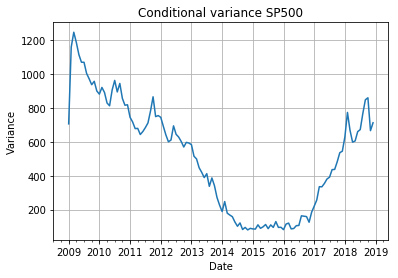

In [179]:
fig, ax = plt.subplots()
arch_model(SP, vol="GARCH", p=1, q=1).fit().conditional_volatility.plot(ax=ax,title="Conditional variance SP500")
ax.set(xlabel="Date",ylabel="Variance")
plt.grid()

# Residual analysis

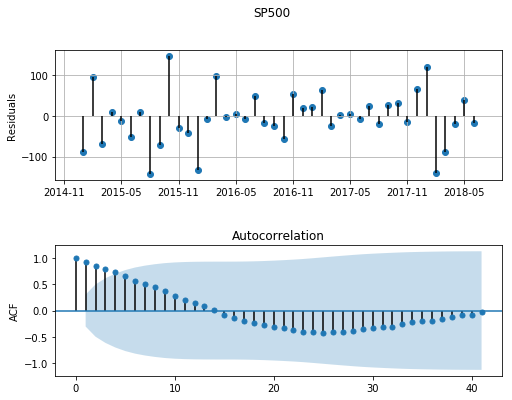

In [383]:

def residualplot(model, data, horizon=12, Start="2015-01-01", Label=""):
    pred = model.get_prediction(start=Start).predicted_mean
    
    fig = plt.figure(figsize=[8,6])
    plt.suptitle(Label)
    grid = plt.GridSpec(2,1,wspace=0.3, hspace=0.5)
    ax1 = plt.subplot(grid[0,0])
    ax1.set(ylabel="Residuals")
    ax1.grid()
    xs = pred.keys()
    ax1.scatter(xs,data.loc[Start:]-np.exp(pred))
    ax1.vlines(xs, 0, data.loc[Start:]-np.exp(pred))

    ax2 = plt.subplot(grid[1,0])
    plot_acf(pred, ax=ax2);
    ax2.set(ylabel="ACF")

residualplot(SP_SARIMAX_fit212, np.exp(SP_train), Label="SP500")

# Break points

breaks_cusumolsresid <br>
cusum test for parameter stability based on ols residuals<br>
breaks_hansen<br>
test for model stability, breaks in parameters for ols, Hansen 1992<br>
recursive_olsresiduals<br>
Calculate recursive ols with residuals and cusum test statistic. This is currently mainly helper function for recursive residual based tests. However, since it uses recursive updating and doesn’t estimate separate problems it should be also quite efficient as expanding OLS function.


https://en.wikipedia.org/wiki/Structural_break


# Crosscorrelation

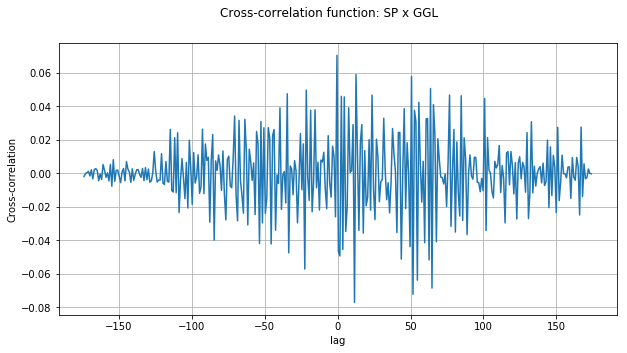

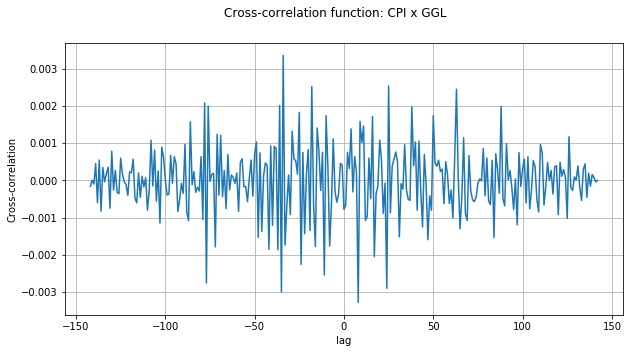

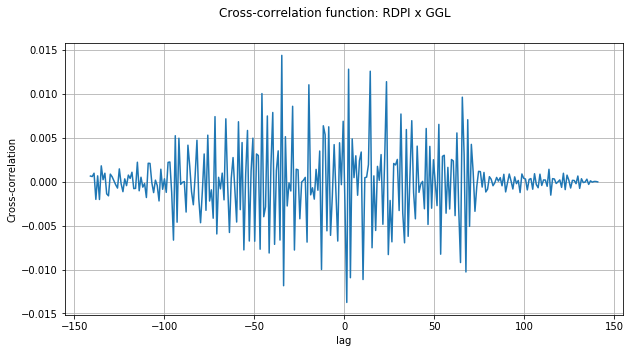

In [60]:
GGLdiff2 = np.log(data["Google"]["Top5"]).diff(12).diff(1).dropna()
SPdiff2 = np.log(data["SP500"]["Close"]).diff(1).diff(1).dropna()

def xcorr(data1, data2, Title=""):
    '''method:
    r_xy = (sum((x_i - x.mean)(y_i-y.mean)))/(sqrt(sum((x_i - x.mean)**2)sum((y_i-y.mean)**2)))
    '''
    ys = correlate(data1, data2, method="direct")
    xs = np.linspace(0-len(ys)//2, 0+len(ys)//2, len(ys))
    fig, ax = plt.subplots(1,1,figsize=[10,5])
    fig.suptitle(f"Cross-correlation function: {Title}")
#     ax[1].plot(xs,ys)
#     ax[1].grid()
#     ax[1].set(ylabel="Cross-correlation", xlabel="lag",xlim=[-20,20])
#     ax[1].annotate("lag=0.5", xy=(-0.5,ys.max()), xytext=(2.5,ys.max()),fontsize=15,arrowprops=dict(facecolor='black', shrink=0.05))
    ax.plot(xs,ys)
    ax.grid()
    ax.set(ylabel="Cross-correlation", xlabel="lag")

xcorr(SPdiff2, GGLdiff2, "SP x GGL")
xcorr(np.log(CPI).diff(1).diff(1).dropna(), GGLdiff2, "CPI x GGL")
xcorr(np.log(RDPI).diff(1).diff(1).dropna(), GGLdiff2, "RDPI x GGL")

# VAR and ARDL

for VAR assume no co-linearity/co-integration:<br>
1) Ignore it. If prediction of y values is the object of your study, then collinearity is not a problem. <br>
2) Use an estimator of the regression coefficients other than the least squares estimators. An alternative is to use ridge regression estimators; Draper and Smith (1981), Applied Regression Analysis, 2nd edition, pp. 313-324. <br>
3) Get rid of the “redundant” variables by using a variable selection technique.

In [21]:
def optimise_VARMAX(data, maxpq):
    ''' iterates through p and q and outputs best AIC, BIC, HQIC order fits'''
    tests = ["AIC", "BIC", "HQIC"]
    results = {}

    for p in range(1,maxpq[0]+1):
        for q in range(1,maxpq[1]+1):
            pqorder = (p,q)
#             print(f"order: {pqorder}")
            mod_fit = VARMAX(data, order=pqorder, maxiter=200, method="powel").fit()
            AIC = mod_fit.aic
            BIC = mod_fit.bic
            HQIC = mod_fit.hqic
            results[pqorder] = (AIC,BIC,HQIC)
    results = pd.DataFrame(results, index=tests).T
    print("\n")
# choose minimum
    for i in range(len(tests)):
        print(f"{tests[i]} minimised at: \n", results[tests[i]][results[tests[i]]==results[tests[i]].min()])
    return results

In [241]:
for shifts in range(-4,5):
    print("shift:",shifts)
    VARset = pd.DataFrame()
    VARset["SP"] = SP_log_diff2["Close"]
    VARset["GGLshifted"] = GGL_log_diff.shift(shifts).dropna()
    optimise_VARMAX(VARset, maxpq=(3,3))



shift: -1


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret



AIC minimised at: 
 1  2   -778.280714
Name: AIC, dtype: float64
BIC minimised at: 
 1  1   -738.719167
Name: BIC, dtype: float64
HQIC minimised at: 
 1  1   -760.113332
Name: HQIC, dtype: float64
shift: 0


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferre



AIC minimised at: 
 1  1   -783.738428
Name: AIC, dtype: float64
BIC minimised at: 
 1  1   -747.719528
Name: BIC, dtype: float64
HQIC minimised at: 
 1  1   -769.113693
Name: HQIC, dtype: float64


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Even though the cross correlation showed that google has a half a step predictability, this would only be useful if we had more data points at higher frequency. As seen from the above iterations, all test results show an improvement when the google data is not shifted.

shift | -AIC | -BIC
------|----|----
-4| 776| 740 <br>
-3| 780| 742 <br>
-2| 779| 737 <br>
-1| 778| 738 <br>
$\rightarrow$__0__| __783__| __747__ <br>
1| 780| 744 <br>
2| 776| 740 <br>
3| 772| 736 <br>
4| 770| 733 <br>

In [22]:
def forecastplot(data1,forecasts):
    fig, axes = plt.subplots()
    data1.loc["2016-06-01":].plot(ax=axes, label="SP500")
    forecasts.plot(ax=axes, label="forecast")
    axes.legend()
    axes.grid()

In [12]:
# VAR data vector
VAR_GGL_SP = pd.DataFrame()
VAR_GGL_SP["SP"] = np.log(SP[:round(len(SP)*0.95)])
VAR_GGL_SP["GGL"] = np.log(GGL[:round(len(SP)*0.9)]) 

In [13]:
# var_model11 = VARMAX(VAR_GGL_SP.loc["2009-06-01":], order=(1,1)).fit()
# var_model31 = VARMAX(VAR_GGL_SP.loc["2009-06-01":], order=(3,1)).fit()
var_model6_12 = VARMAX(VAR_GGL_SP.loc["2009-06-01":], order=(6,12)).fit()

# var_model11.summary()

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [25]:
var_model6_12.summary()

C:\Users\sherv\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sherv\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sherv\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Dep. Variable:,"['SP', 'GGL']",No. Observations:,109
Model:,"VARMA(6,12)",Log Likelihood,312.856
,+ intercept,AIC,-471.713
Date:,"Sat, 28 Sep 2019",BIC,-264.479
Time:,14:53:59,HQIC,-387.672
Sample:,06-01-2009,,
,- 06-01-2018,,
Covariance Type:,opg,,
Ljung-Box (Q):,"31.56, nan",Jarque-Bera (JB):,"1.77, 29.75"
Prob(Q):,"0.83, nan",Prob(JB):,"0.41, 0.00"
Heteroskedasticity (H):,"0.56, 0.61",Skew:,"-0.31, 0.88"


In [14]:
var_model21 = VARMAX(VAR_GGL_SP.loc["2009-06-01":], order=(2,1)).fit()
var_model21.summary()
# var_model6_12.get_forecast(12)

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\sherv\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x)

Dep. Variable:,"['SP', 'GGL']",No. Observations:,109
Model:,"VARMA(2,1)",Log Likelihood,254.892
,+ intercept,AIC,-475.784
Date:,"Thu, 03 Oct 2019",BIC,-430.031
Time:,16:59:57,HQIC,-457.229
Sample:,06-01-2009,,
,- 06-01-2018,,
Covariance Type:,opg,,
Ljung-Box (Q):,"22.98, nan",Jarque-Bera (JB):,"10.55, 44.20"
Prob(Q):,"0.99, nan",Prob(JB):,"0.01, 0.00"
Heteroskedasticity (H):,"0.45, 0.91",Skew:,"-0.70, 1.07"


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


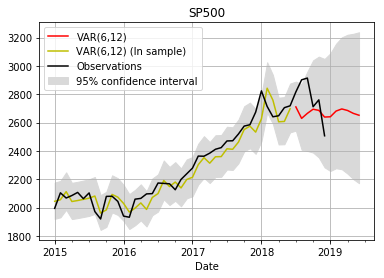

In [16]:


fig, ax = plt.subplots()
plt.title("SP500")

forc=var_model6_12.get_forecast(12)
pred = var_model6_12.get_prediction(start="2015-01-01")

pred_low_conf_int,pred_up_conf_int = pred.conf_int().iloc[:,0],pred.conf_int().iloc[:,2]
forc_low_conf_int,forc_up_conf_int = forc.conf_int().iloc[:,0],forc.conf_int().iloc[:,2]

lower = pd.concat([pred_low_conf_int, forc_low_conf_int])
upper = pd.concat([pred_up_conf_int, forc_up_conf_int])

xs = lower.keys()

np.exp(forc.predicted_mean)["SP"].plot(label="VAR(6,12)", color="r", ax=ax)

ax.fill_between(xs,np.exp(lower),np.exp(upper), color="0.85", label="95% confidence interval")

np.exp(pred.predicted_mean["SP"]).plot(ax=ax,label="VAR(6,12) (In sample)", color="y")

SP.loc["2015-01-01":].plot(label="Observations", color="k",ax=ax)

plt.grid()
plt.legend()



MSE bias: 88.0
SP mean: 18
Predictor mean: 16


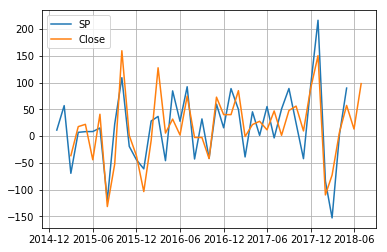

In [91]:
temp = list(np.exp(pred.predicted_mean["SP"]).diff(1).shift(-1).dropna())
temp2 = list(SP.loc["2015-01-01":"2018-06-01"].diff(1).dropna())
sigma = 0
if len(temp)== len(temp2):
    for i in range(len(temp)):
        Sqrd_Err = (temp[i]-temp2[i])**2
        sigma+= Sqrd_Err

    MSE_bias = sigma/len(temp)

plt.plot(np.exp(pred.predicted_mean["SP"]).diff(1).shift(-1).dropna())
plt.plot(SP.loc["2015-02-01":"2018-07-01"].diff(1).dropna())
plt.legend()
plt.grid()

print("MSE bias:", round(np.sqrt(MSE_bias)))
print("SP mean:", round(sum(SP.loc["2015-01-01":"2018-6-01"].diff(1).dropna())/len(temp)))
print("Predictor mean:", round(Expec_A))
# theres a massive bias
# TODO: shift to the right by 1 instance and re check the bias

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


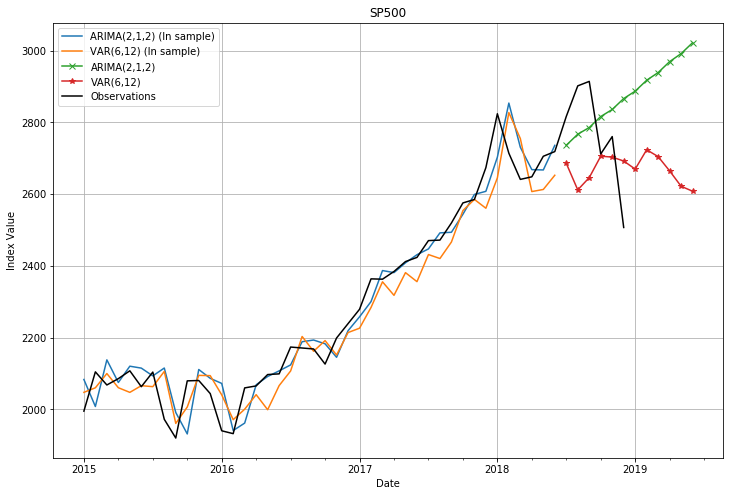

In [349]:


fig, ax = plt.subplots(figsize=[12,8])
plt.title("SP500")
# np.exp(SP_SARIMAX_fit0115_forecast).plot(label="ARIMA(0,1,15)", color="r")
# np.exp(var_model6_12.forecast(steps=24)["SP"]).plot(label="VAR(6,12)")
np.exp(SP_SARIMAX_fit212.get_prediction("2015-01-01").predicted_mean).plot(ax=ax, label="ARIMA(2,1,2) (In sample)")
np.exp(var_model6_12.get_prediction(start="2015-01-01").predicted_mean["SP"]).plot(ax=ax, label="VAR(6,12) (In sample)")

np.exp(SP_SARIMAX_fit212.get_forecast(12).predicted_mean).plot(ax=ax, label="ARIMA(2,1,2)", marker="x")
np.exp(var_model6_12.get_forecast(12).predicted_mean["SP"]).plot(ax=ax, label="VAR(6,12)", marker="*")

# np.exp(var_model6_12.predict(start="2015-01-01")["SP"]).plot(label="VAR(6,12) (In sample)")
# plt.scatter(VAR_GGL_SP["SP"]["2015-01-01":].keys(),np.exp(VAR_GGL_SP["SP"]["2015-01-01":]),label="Observations", color="k", marker="x")
SP.loc["2015-01-01":].plot(label="Observations", color="k")

plt.ylabel("Index Value")
plt.grid()
plt.legend()


[Text(0.5,0,'Residual distribution')]

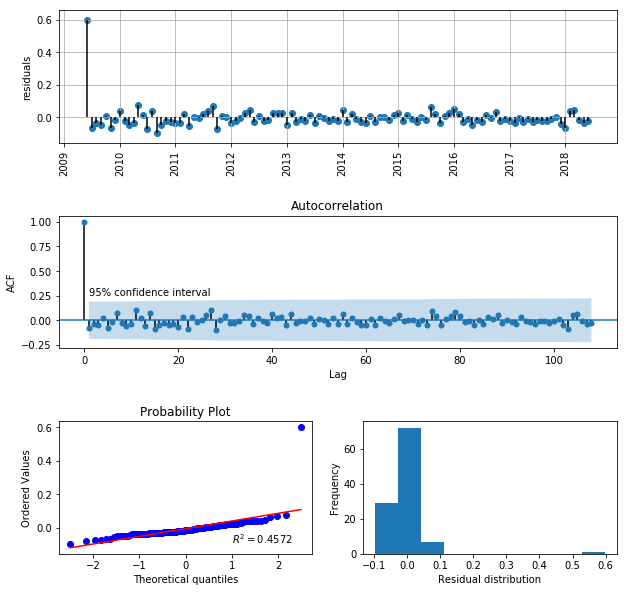

In [354]:
plt.figure(figsize=[10,10])
grid=plt.GridSpec(3,2, hspace=0.55)

ax1=plt.subplot(grid[0,:])
ys = var_model6_12.get_prediction().predicted_mean["SP"]-np.log(SP.loc["2009-06-01":"2018-06-01"])
xs = SP.loc["2009-06-01":"2018-06-01"].keys()
ax1.scatter(xs,ys)
ax1.vlines(xs,0,ys)
ax1.grid()
ax1.set(ylabel="residuals")
plt.xticks(rotation="vertical")

ax2= plt.subplot(grid[1,:])
plot_acf(ys.dropna(), ax=ax2);
ax2.set(ylabel="ACF", xlabel="Lag")
ax2.text(1,0.25, "95% confidence interval")

ax3= plt.subplot(grid[2,0])
probplot(ys.dropna(), plot=ax3, rvalue=True)

ax4= plt.subplot(grid[2,1])
ys.dropna().plot(kind="hist", ax=ax4)
ax4.set(xlabel="Residual distribution")

[Text(0.5,0,'Residual distribution')]

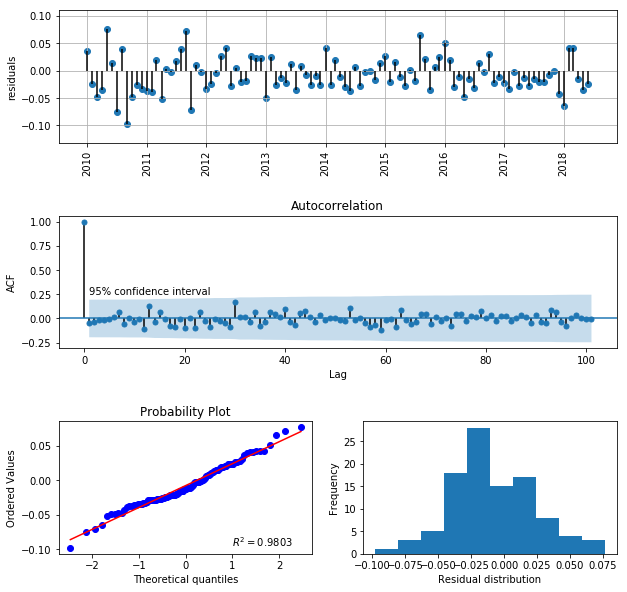

In [355]:
plt.figure(figsize=[10,10])
grid=plt.GridSpec(3,2, hspace=0.55)

ax1=plt.subplot(grid[0,:])
ys = var_model6_12.get_prediction().predicted_mean["SP"].loc["2010-01-01":"2018-06-01"]-np.log(SP.loc["2010-01-01":"2018-06-01"])
xs = SP.loc["2010-01-01":"2018-06-01"].keys()
ax1.scatter(xs,ys)
ax1.vlines(xs,0,ys)
ax1.grid()
ax1.set(ylabel="residuals")
plt.xticks(rotation="vertical")

ax2= plt.subplot(grid[1,:])
plot_acf(ys.dropna(), ax=ax2);
ax2.set(ylabel="ACF", xlabel="Lag")
ax2.text(1,0.25, "95% confidence interval")

ax3= plt.subplot(grid[2,0])
probplot(ys.dropna(), plot=ax3, rvalue=True)

ax4= plt.subplot(grid[2,1])
ys.dropna().plot(kind="hist", ax=ax4)
ax4.set(xlabel="Residual distribution")

# Breakpoints

Beginning of 2009 shows a period of high volatility which can cause inaccuracies in the forecast. Therefore, it is suggested that the training data start from mid 2009 or 2010 to eliminate any serial correaltion between the break and the train data.

In [64]:
# Students' t-test

ACF = acf(SP_train, nlags=120)
mu = ACF.mean()
std = ACF.std()

t_stat = []
for i in range(len(ACF)):
    rho = ACF[i]
    nom = (rho*np.sqrt(len(ACF)-2))
    denom = (np.sqrt(1-rho**2))
    if denom == 0:
        pass
    else:
        t_stat.append(nom/denom)
counter = 0
for t in t_stat:
    if t<2.04:
        counter+=1
    else:
        pass
print(f"{counter} lags are significant")

79 lags are significant


removing the outliers and starting the model from 2009-06-01, the AIC, BIC and HQIC were reduced another 3.7, 4.04 and 3.7 points to 787.45, 751.77, 772.97 respectively. 

pseudo code, initialise etc...
table with parameters 
Comparison of moddles (ARIMA, VAR, comment on GARCH)
he doesnt like the random noise ACF
spacing of the datapoints 
performance of stationarity (why ADF gave type 1 error)
research in the future (ACF get more data and information, GARCH)
sampling to show the distribution (sampling error)